In [3]:

from langchain_community.vectorstores import Weaviate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_community.chat_models import ChatOllama

import weaviate
from langchain.globals import set_llm_cache
from langchain.cache import RedisCache
import redis

REDIS_URL = "redis://localhost:6379/0"

redis_client = redis.Redis.from_url(REDIS_URL)
set_llm_cache(RedisCache(redis_client))


client = weaviate.Client(
url="http://localhost:8080",
)

vectorstore = Weaviate(client, 
                    "GRP", 
                    "content")

retriever = vectorstore.as_retriever()



# RAG prompt
template = """You're an Friendly AI assistant, your name is Claro, you can make normal conversations in a friendly manner, and also provide Answer the question based on the following context make sure it sounds like human and official assistant:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)




# RAG
model = ChatOllama(model="openhermes:7b-mistral-v2-q8_0")
# model = ChatOllama(model="falcon:40b-instruct-q4_1")
chain = (
    RunnableParallel({"context": retriever, "question": RunnablePassthrough()})
    | prompt
    | model
    # | StrOutputParser()
)



# Add typing for input
class Question(BaseModel):
    __root__: str


chain = chain.with_types(input_type=Question)



/home/amaithi/projects/weaviate/langgraph-final/.venv/lib/python3.11/site-packages/weaviate/warnings.py:121: DeprecationWarning: Dep005: You are using weaviate-client version 3.26.2. The latest version is 4.5.5.
            Please consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(


In [4]:
result = chain.invoke('what is mediwave')

OllamaEndpointNotFoundError: Ollama call failed with status code 404. Maybe your model is not found and you should pull the model with `ollama pull openhermes:7b-mistral-v2-q8_0`.

In [ ]:
result

In [ ]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [ ]:
from grp_food_crew_ai.grp_food_crewai import food_crew


result = food_crew(input='how to make vanilla sponge cake give me the receipe only')


In [ ]:
print(result)

In [ ]:
from grp_food_crew_ai.grp_food_crewai import food_crew


result = food_crew(input='how to make vanilla sponge cake, give me the receipe')

print(food_crew.usage_metrics())

In [ ]:
print(result)

In [ ]:
a = 5 
a

# TRavel

In [ ]:
from langchain.globals import set_debug, set_verbose
from dotenv import load_dotenv
load_dotenv()
# set_verbose(True)
# set_debug(True)

import os

from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_experimental.llms.ollama_functions import OllamaFunctions

# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning) 

import warnings
warnings.filterwarnings("ignore")

# members = ["Food_crew", "General_conversation", "General_other", "Mediwave_rag", "Travel_crew"]


members = ["Food_crew", "General_conv", "General_other", "Mediwave_rag", "Travel_crew"]

system_prompt = (
    """You are a supervisor tasked with managing a conversation between the
     following workers:  {members}. Given the following user request,"
     respond with the worker to act next. 
     
     if the user asks anything related to food, receipies, and it's related stuffs use 'Food_crew',
    if the user asks anything related to mediwave and it's related stuffs use 'Mediwave_rag',    
    if the user makes conversation, jokes and funny conversations then use 'General_conv',
    if the user asks anything related to weather, time, wikipedia and it's related stuffs use 'General_other',
    if the user asks anything related to travel, exploration, city tour and it's related stuffs use 'Travel_crew'
        
    Each worker will perform a
     task and respond with their results and status. When finished,
    respond with FINISH."""
)

# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role to act",
    
    "parameters": {
        "type": "object",        
        "properties": {
            "next": {
                "type": "string",
                "enum": f"{options}",
            }
        },
        "required": ["next"],
    },
}


DEFAULT_SYSTEM_TEMPLATE = """You have access to the following tools:

{tools}

You must always select one of the above tools and respond with only a JSON object matching the following schema:

{{
  "tool": "route",
  "tool_input": <parameters for the selected tool, matching the tool's JSON schema>
}}
""" 


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = OllamaFunctions(
    model=os.environ['LLM'],
    tool_system_prompt_template=DEFAULT_SYSTEM_TEMPLATE
    )


def supervisor_node(state):

    print(state)
    
    supervisor_chain = (
        prompt
        | llm.bind(functions=[function_def], function_call={"name": "route"})
        | JsonOutputFunctionsParser()
    )
        
    result = supervisor_chain.invoke(state)
    
    return result





import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str



from grp_travel_crew_ai.grp_travel_crewai import travel_crew

from grp_RAG1.grp_rag1_rag import mediwave_rag

from grp_others.grp_others_graph import grp_other_def as gen_others

from grp_food_crew_ai.grp_food_crewai import food_crew

from grp_Gen_Conv.grp_gen_conv_chain import general_conversation



workflow = StateGraph(AgentState)

workflow.add_node("Food_crew", food_crew)
workflow.add_node("General_conv", general_conversation)
workflow.add_node("General_other", gen_others)
workflow.add_node("Mediwave_rag", mediwave_rag)
workflow.add_node("Travel_crew", travel_crew)

workflow.add_node("supervisor", supervisor_node)




for member in members:
    
    if member == 'Mediwave_rag':
        continue
    if member == 'Travel_crew':
        continue
    
    
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
    

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes


conditional_map = {k: k for k in members}



conditional_map["FINISH"] = END
# conditional_map['supervisor'] ='supervisor'

workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# Finally, add entrypoint
workflow.set_entry_point("supervisor")
workflow.set_finish_point('Mediwave_rag')
workflow.set_finish_point('General_conv')
workflow.set_finish_point('Travel_crew')


graph = workflow.compile()


In [ ]:
result = graph.invoke({
        "messages": [
            HumanMessage(
                content="what is the current weather in pondicherry"
            )
        ],
    })
result

In [ ]:
from langchain import hub 

hub.pull("hwchase17/react")

In [ ]:
result

In [ ]:
result = graph.invoke({
        "messages": [
            HumanMessage(
                content="suggest some good spots to visit during summer in kodaikanal and ooty give me a complete 7 day itenary with travel route and food, budget accomodation and other nearby scenic spots and tourist atractions, start from pondicherry and return pondicherry after last day."
            )
        ],
    })

In [ ]:
result = graph.invoke({
        "messages": [
            HumanMessage(
                content="suggest some good spots to visit during summer in ooty and give me a 3 day itenary, start from pondicherry and return pondicherry after third day"
            )
        ],
    })

In [ ]:
"The user's travel needs in Ooty during summer can be met by visiting several top attractions over a 3-day itinerary, starting and ending in Pondicherry. Here is the detailed plan:\n\nDay 1:\n- Visit Dodabetta Peak, the highest point in Ooty, offering breathtaking views of the surrounding mountains and valleys.\n- Explore Mudumalai Wildlife Sanctuary, a large protected area known for its diverse wildlife population, including elephants, tigers, and various bird species.\n\nDay 2:\n- Spend the morning at the Botanical Gardens, home to a vast collection of exotic plants, flowers, and trees.\n- In the afternoon, visit Emerald Lake, a serene and picturesque lake nestled in the heart of Ooty.\n- End the day by relaxing at Ooty Lake, enjoying a peaceful boat ride or taking a leisurely walk around the lake.\n\nDay 3:\n- Begin the day with a visit to Pykara Falls, located approximately 20 km from Ooty, known for its stunning beauty and the surrounding lush greenery.\n- In the afternoon, head towards Coonoor, a nearby hill station famous for its tea gardens. Take a tour of the gardens and learn about the tea-making process.\n\nBy following this itinerary, the user will get to experience the best of Ooty's natural beauty, cultural attractions, and local experiences during their summer vacation."

In [ ]:
result = graph.invoke({
        "messages": [
            HumanMessage(
                content="suggest some good spots to visit during summer in mysore and give me a 3 day itenary, start from pondicherry and return pondicherry after third day"
            )
        ],
    })

In [ ]:
"Here's a detailed response summarizing key findings about the given context and information that could be relevant to it: The user is looking for travel suggestions in Mysore during summer and requires a three-day itinerary starting from Pondicherry. Based on your request, I have delegated this task to our Travel agency manager. Here's the suggested itinerary:\n\nDay 1:\n- Depart from Pondicherry early morning by road, which is approximately a 4-hour drive.\n- Visit the Chamundeshwari Temple located on Chamundi Hill, known for its religious significance and beautiful views of Mysore city.\n- Head to Brindavan Gardens, located in the Krishnarajasagar Dam area, famous for its terrace gardens, fountains, and musical fountain show.\n- Overnight stay at a hotel in Mysore.\n\nDay 2:\n- Visit the Mysore Palace, a grand architectural marvel open to public viewing during summer months. Don't forget to check out the famous Dussehra durbar hall.\n- Explore the Sri Chamarajendra Zoo and Museum located in the heart of Mysore city. The zoo is home to a wide variety of animals, and the museum exhibits artifacts related to the history and culture of Mysore.\n- Visit the St. Philomena's Church, an impressive Roman Catholic basilica known for its neo-Gothic architecture.\n- Overnight stay at a hotel in Mysore.\n\nDay 3:\n- Depart from Mysore early morning and head back to Pondicherry by road.\n- En route, stop at the Ranganathittu Bird Sanctuary located near Srirangapatna, famous for its diverse bird population and scenic beauty.\n- Arrive in Pondicherry late afternoon/evening and complete your journey.\n\nPlease note that travel times may vary depending on traffic conditions, so it's always a good idea to leave early. Additionally, make sure to check the opening hours of each attraction before planning your visit. Let me know if you need any further assistance with this itinerary or if there are any modifications you would like me to make."

In [ ]:
for s in graph.stream(input=
    {
        "messages": [
            HumanMessage(
                content="suggest some good spots to visit during summer in mysore and give me a 3 day itenary, start from pondicherry and return pondicherry after third day"
            )
        ],
    },
    config= {"recursion_limit": 100},
    
):
    if "__end__" not in s:
        print(s)
        print("---")


In [ ]:
for s in graph.stream(input=
    {
        "messages": [
            HumanMessage(
                content="suggest some good spots to visit during summer in pondicherry and give me a 2 day itenary"
            )
        ],
    },
    config= {"recursion_limit": 100},
    
):
    if "__end__" not in s:
        print(s)
        print("---")


In [ ]:
for s in graph.stream(input=
    {
        "messages": [
            HumanMessage(
                content="suggest some good spots to visit during summer in pondicherry and give me a 2 day itenary"
            )
        ],
    },
    config= {"recursion_limit": 100},
    
):
    if "__end__" not in s:
        print(s)
        print("---")


In [ ]:
for s in graph.stream(input=
    {
        "messages": [
            HumanMessage(
                content="suggest some good spots to visit during summer in pondicherry and give me a 2 day itenary"
            )
        ],
    },
    config= {"recursion_limit": 100},
    
):
    if "__end__" not in s:
        print(s)
        print("---")


In [ ]:
result = graph.invoke({
        "messages": [
            HumanMessage(
                content="suggest some good spots to visit during summer in pondicherry and give me a 2 day itenary"
            )
        ],
    })

In [ ]:
result

In [ ]:
graph.invoke({
        "messages": [
            HumanMessage(
                content="what is the time now"
            )
        ],
    })

# Supervisor - update

In [ ]:
from langchain.globals import set_debug, set_verbose
from dotenv import load_dotenv
load_dotenv()
# set_verbose(True)
# set_debug(True)

import os

from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_experimental.llms.ollama_functions import OllamaFunctions

# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning) 

import warnings
warnings.filterwarnings("ignore")

# members = ["Food_crew", "General_conversation", "General_other", "Mediwave_rag", "Travel_crew"]


members = ["Food_crew", "General_conv", "General_other", "Mediwave_rag", "Travel_crew"]

system_prompt = (
    """You are a supervisor tasked with managing a conversation between the
     following workers:  {members}. Given the following user request,"
     respond with the worker to act next. 
     
     if the user asks anything related to food, receipies, and it's related stuffs use 'Food_crew',
    if the user asks anything related to mediwave and it's related stuffs use 'Mediwave_rag',    
    if the user makes conversation, jokes and funny conversations then use 'General_conv',
    if the user asks anything related to weather, time, wikipedia and it's related stuffs use 'General_other',
    if the user asks anything related to travel, exploration, city tour and it's related stuffs use 'Travel_crew'
        
    Each worker will perform a
     task and respond with their results and status. When finished,
    respond with FINISH."""
)

# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role to act",
    
    "parameters": {
        "type": "object",        
        "properties": {
            "next": {
                "type": "string",
                "enum": f"{options}",
            }
        },
        "required": ["next"],
    },
}


DEFAULT_SYSTEM_TEMPLATE = """You have access to the following tools:

{tools}

You must always select one of the above tools and respond with only a JSON object matching the following schema:

{{
  "tool": "route",
  "tool_input": <parameters for the selected tool, matching the tool's JSON schema>
}}
""" 


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = OllamaFunctions(
    model=os.environ['LLM'],
    tool_system_prompt_template=DEFAULT_SYSTEM_TEMPLATE
    )


def supervisor_node(state):

    print(state)
    
    supervisor_chain = (
        prompt
        | llm.bind(functions=[function_def], function_call={"name": "route"})
        | JsonOutputFunctionsParser()
    )
        
    result = supervisor_chain.invoke(state)
    
    return result





import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str



from grp_travel_crew_ai.grp_travel_crewai import travel_crew

from grp_RAG1.grp_rag1_rag import mediwave_rag

from grp_others.grp_others_graph import grp_other_def as gen_others

from grp_food_crew_ai.grp_food_crewai import food_crew

from grp_Gen_Conv.grp_gen_conv_chain import general_conversation



workflow = StateGraph(AgentState)

workflow.add_node("Food_crew", food_crew)
workflow.add_node("General_conv", general_conversation)
workflow.add_node("General_other", gen_others)
workflow.add_node("Mediwave_rag", mediwave_rag)
workflow.add_node("Travel_crew", travel_crew)

workflow.add_node("supervisor", supervisor_node)




for member in members:
    
    if member == 'Mediwave_rag':
        continue
    if member == 'Travel_crew':
        continue
    
    
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
    

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes


conditional_map = {k: k for k in members}



conditional_map["FINISH"] = END
# conditional_map['supervisor'] ='supervisor'

workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# Finally, add entrypoint
workflow.set_entry_point("supervisor")
workflow.set_finish_point('Mediwave_rag')
workflow.set_finish_point('General_conv')
workflow.set_finish_point('Travel_crew')


graph = workflow.compile()


In [ ]:
from plan_and_execute.graph import graph 

graph.get_input_schema



In [ ]:
from plan_and_execute.graph import graph 



graph.get_input_schema

In [1]:
from langchain_core.runnables import chain
from langchain_core.messages import AIMessage

from langchain.globals import set_debug, set_verbose
from plan_and_execute.graph import graph 


set_verbose=True 
set_debug=True



@chain
async def custom_chain(input):
    
    result = await graph.ainvoke({"input": input})
    
    # print(result)
    
    return AIMessage(content=result['response'])

res = await custom_chain.ainvoke(input='suggest some good spots in pondicherry')



Attempting to load an OpenAPI 3.0.0 spec.  This may result in degraded performance. Convert your OpenAPI spec to 3.1.* spec for better support.
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Content-Type. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Accept. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Content-Type. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Accept. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Content-Type. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Accept. Valid values are ['query', 'path'] Ig

CancelledError: 

In [2]:
{
  "tool": "output_formatter",
  "tool_input": {
    "plan": [
      {
        "key": "Mediwave_rag",
        "value": "Describe Mediwave"
      },
      {
        "key": "General_other",
        "value": "Get current time"
      }
    ]
  }
}

AIMessage(content='Mediwave Digital is a healthcare technology and clinical research company that combines user-centered design with agile development. They have worked on several projects, one of which is the Sefton & Liverpool CAMHS platform built using Node.js, MongoDB, Apostrophe CMS + Node.js, PostgreSQL, and Sequelize. The current time is...')

In [1]:
from langchain_core.messages import HumanMessage
from plan_and_execute.graph import graph 
import warnings
warnings.filterwarnings('ignore')


config = {"recursion_limit": 50}
inputs = {"input": "suggest some good tourist spots in pondicherry"}
async for event in graph.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v, end="\n\n")

Attempting to load an OpenAPI 3.0.0 spec.  This may result in degraded performance. Convert your OpenAPI spec to 3.1.* spec for better support.
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Content-Type. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Accept. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Content-Type. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Accept. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Content-Type. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Accept. Valid values are ['query', 'path'] Ig

ValueError: Failed to parse a function call from mistral:7b-instruct-q6_K output: {
  "tool": "Travel_crew",
  "tool_input": {
    "plan": [
      {
        "key": "Food_crew",
        "value": "suggesting food spots"
      },
      {
        "key": "General_other",
        "value": "suggesting tourist spots"
      }
    ]
  }
}

In [2]:
from langchain_core.utils.function_calling import (
    convert_to_openai_function,
    convert_to_openai_tool,
)
from langchain_core.pydantic_v1 import BaseModel

class Response(BaseModel):
    """Response to user."""

    response: str

convert_to_openai_function(Response)

{'name': 'Response',
 'description': 'Response to user.',
 'parameters': {'type': 'object',
  'properties': {'response': {'type': 'string'}},
  'required': ['response']}}

# open ai function runnable

In [1]:
import json
from typing import Any, Callable, Dict, Literal, Optional, Sequence, Type, Union

from langchain_core.output_parsers import (
    BaseGenerationOutputParser,
    BaseOutputParser,
    JsonOutputParser,
)
from langchain_core.output_parsers.openai_functions import (
    JsonOutputFunctionsParser,
    PydanticAttrOutputFunctionsParser,
    PydanticOutputFunctionsParser,
)
from langchain_core.prompts import BasePromptTemplate
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.runnables import Runnable
from langchain_core.utils.function_calling import (
    convert_to_openai_function,
    convert_to_openai_tool,
)

from langchain.output_parsers import (
    JsonOutputKeyToolsParser,
    PydanticOutputParser,
    PydanticToolsParser,
)


def create_openai_fn_runnable(
    functions: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable]],
    llm: Runnable,
    prompt: Optional[BasePromptTemplate] = None,
    *,
    enforce_single_function_usage: bool = True,
    output_parser: Optional[Union[BaseOutputParser, BaseGenerationOutputParser]] = None,
    **llm_kwargs: Any,
) -> Runnable:
   
    # noqa: E501
    if not functions:
        raise ValueError("Need to pass in at least one function. Received zero.")
    openai_functions = [convert_to_openai_function(f) for f in functions]
    llm_kwargs_: Dict[str, Any] = {"functions": openai_functions}
    if len(openai_functions) == 1 and enforce_single_function_usage:
        llm_kwargs_["function_call"] = {"name": openai_functions[0]["name"]}
    output_parser = output_parser or get_openai_output_parser(functions)
    if prompt:
        return prompt | llm.bind(functions=openai_functions) | output_parser
    else:
        return llm.bind(**llm_kwargs_) | output_parser


def get_openai_output_parser(
    functions: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable]],
) -> Union[BaseOutputParser, BaseGenerationOutputParser]:
    """Get the appropriate function output parser given the user functions.

    Args:
        functions: Sequence where element is a dictionary, a pydantic.BaseModel class,
            or a Python function. If a dictionary is passed in, it is assumed to
            already be a valid OpenAI function.

    Returns:
        A PydanticOutputFunctionsParser if functions are Pydantic classes, otherwise
            a JsonOutputFunctionsParser. If there's only one function and it is
            not a Pydantic class, then the output parser will automatically extract
            only the function arguments and not the function name.
    """
    if isinstance(functions[0], type) and issubclass(functions[0], BaseModel):
        if len(functions) > 1:
            pydantic_schema: Union[Dict, Type[BaseModel]] = {
                convert_to_openai_function(fn)["name"]: fn for fn in functions
            }
        else:
            pydantic_schema = functions[0]
        output_parser: Union[
            BaseOutputParser, BaseGenerationOutputParser
        ] = PydanticOutputFunctionsParser(pydantic_schema=pydantic_schema)
    else:
        output_parser = JsonOutputFunctionsParser(args_only=len(functions) <= 1)
    return output_parser




In [2]:
state = {'input': 'tell me about mediwave and also give the current time', 'plan': [{'key': 'Mediwave_rag', 'value': 'Explain about Mediwave'}, {'key': 'General_other', 'value': 'Get current time'}], 'past_steps': ('Explain about Mediwave', " Claro: I'd be happy to help explain a bit more about Mediwave Digital! They are a company dedicated to addressing the world's needs by empowering over 50 brands to thrive and make a meaningful impact. As a design-thinking company, they focus on creating not only digital products and services but also transformative experiences.\n\nTheir team consists of talented UI/UX designers, full-stack developers, QA engineers, and DevOps programmers who collaborate from conceptualization through development, testing, and deployment. They emphasize a pursuit of excellence and innovation in all their projects.\n\nMediwave Digital has a strong focus on healthcare technology and clinical research, combining user-centered design with agile development. One of their notable achievements is their collaboration with Sefton & Liverpool CAMHS services to promote mental health and well-being for children, young people, families, and carers through a dedicated platform. Their tech stack includes Node.js, MangoDB, Apostrophe CMS + Node.js, PostgreSQL, and Sequelize.\n\nThey pride themselves on their collaborative efforts and the impact they make with their work. Matt Rigby, Head of Digital at Brook, expressed his gratitude for Mediwave's role in their team and project DFD. Overall, Mediwave is a culture-driven design company that thrives on tackling big challenges and making a tangible difference with their work. If you are interested in joining them on their mission to assist companies in delivering delightful customer experiences, they offer opportunities for Full Stack Developers."), 'response': None}

In [3]:

state_ = state.copy()

plan_steps = []

# m = [val for key, val in item.items() for item in g]

for item in state['plan']:
    # print(item['value'])
    plan_steps.append(item['value'])
    # for val in item.values():
    #     # k.append(val)
    #     print(val)
        
plan_steps

state_ |= {'plan': plan_steps}
state_

{'input': 'tell me about mediwave and also give the current time',
 'plan': ['Explain about Mediwave', 'Get current time'],
 'past_steps': ('Explain about Mediwave',
  " Claro: I'd be happy to help explain a bit more about Mediwave Digital! They are a company dedicated to addressing the world's needs by empowering over 50 brands to thrive and make a meaningful impact. As a design-thinking company, they focus on creating not only digital products and services but also transformative experiences.\n\nTheir team consists of talented UI/UX designers, full-stack developers, QA engineers, and DevOps programmers who collaborate from conceptualization through development, testing, and deployment. They emphasize a pursuit of excellence and innovation in all their projects.\n\nMediwave Digital has a strong focus on healthcare technology and clinical research, combining user-centered design with agile development. One of their notable achievements is their collaboration with Sefton & Liverpool CAM

In [1]:
# Begin

In [1]:
import json
from typing import Any, Dict, List, Optional

from langchain_community.chat_models.ollama import ChatOllama
from langchain_core.callbacks import CallbackManagerForLLMRun
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import AIMessage, BaseMessage
from langchain_core.outputs import ChatGeneration, ChatResult
from langchain_core.prompts import SystemMessagePromptTemplate

from langchain_experimental.pydantic_v1 import root_validator

DEFAULT_SYSTEM_TEMPLATE = """You have access to the following tools:

{tools}

You must always select one of the above tools and respond with only a JSON object matching the following schema:

{{
  "tool": <name of the selected tool>,
  "tool_input": <parameters for the selected tool, matching the tool's JSON schema>
}}
"""  # noqa: E501


DEFAULT_RESPONSE_FUNCTION = {
    "name": "__conversational_response",
    "description": (
        "Respond conversationally if no other tools should be called for a given query."
    ),
    "parameters": {
        "type": "object",
        "properties": {
            "response": {
                "type": "string",
                "description": "Conversational response to the user.",
            },
        },
        "required": ["response"],
    },
}


class OllamaFunctions(BaseChatModel):
    """Function chat model that uses Ollama API."""

    llm: ChatOllama

    tool_system_prompt_template: str

    @root_validator(pre=True)
    def validate_environment(cls, values: Dict) -> Dict:
        values["llm"] = values.get("llm") or ChatOllama(**values, format="json")
        values["tool_system_prompt_template"] = (
            values.get("tool_system_prompt_template") or DEFAULT_SYSTEM_TEMPLATE
        )
        return values

    @property
    def model(self) -> BaseChatModel:
        """For backwards compatibility."""
        return self.llm

    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:
        functions = kwargs.get("functions", [])
        if "function_call" in kwargs:
            functions = [
                fn for fn in functions if fn["name"] == kwargs["function_call"]["name"]
            ]
            if not functions:
                raise ValueError(
                    'If "function_call" is specified, you must also pass a matching \
function in "functions".'
                )
            del kwargs["function_call"]
        elif not functions:
            functions.append(DEFAULT_RESPONSE_FUNCTION)
        system_message_prompt_template = SystemMessagePromptTemplate.from_template(
            self.tool_system_prompt_template
        )
        system_message = system_message_prompt_template.format(
            tools=json.dumps(functions, indent=2)
        )
        if "functions" in kwargs:
            del kwargs["functions"]
        response_message = self.llm.predict_messages(
            [system_message] + messages, stop=stop, callbacks=run_manager, **kwargs
        )
        chat_generation_content = response_message.content
        if not isinstance(chat_generation_content, str):
            raise ValueError("OllamaFunctions does not support non-string output.")
        try:
            parsed_chat_result = json.loads(chat_generation_content)
        except json.JSONDecodeError:
            raise ValueError(
                f'"{self.llm.model}" did not respond with valid JSON. Please try again.'
            )
        called_tool_name = parsed_chat_result["tool"]
        called_tool_arguments = parsed_chat_result["tool_input"]
        called_tool = next(
            (fn for fn in functions if fn["name"] == called_tool_name), None
        )
        if called_tool is None:
            raise ValueError(
                f"Failed to parse a function call from {self.llm.model} \
output: {chat_generation_content}"
            )
        if called_tool["name"] == DEFAULT_RESPONSE_FUNCTION["name"]:
            return ChatResult(
                generations=[
                    ChatGeneration(
                        message=AIMessage(
                            content=called_tool_arguments["response"],
                        )
                    )
                ]
            )

        response_message_with_functions = AIMessage(
            content="",
            additional_kwargs={
                "function_call": {
                    "name": called_tool_name,
                    "arguments": json.dumps(called_tool_arguments)
                    if called_tool_arguments
                    else "",
                },
            },
        )

        return ChatResult(
            generations=[ChatGeneration(message=response_message_with_functions)]
        )

    @property
    def _llm_type(self) -> str:
        return "ollama_functions"


In [2]:
import json
from typing import Any, Callable, Dict, Literal, Optional, Sequence, Type, Union

from langchain_core.output_parsers import (BaseGenerationOutputParser, BaseOutputParser,)
from langchain_core.output_parsers.openai_functions import (JsonOutputFunctionsParser, PydanticOutputFunctionsParser,)
from langchain_core.prompts import BasePromptTemplate
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.runnables import Runnable
from langchain_core.utils.function_calling import (convert_to_openai_function)

from langchain.output_parsers import (JsonOutputKeyToolsParser, PydanticOutputParser, PydanticToolsParser)


def create_openai_fn_runnable(
    functions: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable]],
    llm: Runnable,
    prompt: Optional[BasePromptTemplate] = None,
    *,
    enforce_single_function_usage: bool = True,
    output_parser: Optional[Union[BaseOutputParser, BaseGenerationOutputParser]] = None,
    **llm_kwargs: Any,
) -> Runnable:
   
    openai_functions = [convert_to_openai_function(f) for f in functions]
    llm_kwargs_: Dict[str, Any] = {"functions": openai_functions, **llm_kwargs}
    
    if len(openai_functions) == 1 and enforce_single_function_usage:
        llm_kwargs_["function_call"] = {"name": openai_functions[0]["name"]}
    output_parser = output_parser or get_openai_output_parser(functions)
    if prompt:
        return prompt | llm.bind(**llm_kwargs_) | output_parser
    else:
        return llm.bind(**llm_kwargs_) | output_parser


def get_openai_output_parser(
    functions: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable]],
) -> Union[BaseOutputParser, BaseGenerationOutputParser]:
    """Get the appropriate function output parser given the user functions.

    Args:
        functions: Sequence where element is a dictionary, a pydantic.BaseModel class,
            or a Python function. If a dictionary is passed in, it is assumed to
            already be a valid OpenAI function.

    Returns:
        A PydanticOutputFunctionsParser if functions are Pydantic classes, otherwise
            a JsonOutputFunctionsParser. If there's only one function and it is
            not a Pydantic class, then the output parser will automatically extract
            only the function arguments and not the function name.
    """
    if isinstance(functions[0], type) and issubclass(functions[0], BaseModel):
        if len(functions) > 1:
            pydantic_schema: Union[Dict, Type[BaseModel]] = {
                convert_to_openai_function(fn)["name"]: fn for fn in functions
            }
        else:
            pydantic_schema = functions[0]
        output_parser: Union[
            BaseOutputParser, BaseGenerationOutputParser
        ] = PydanticOutputFunctionsParser(pydantic_schema=pydantic_schema)
    else:
        output_parser = JsonOutputFunctionsParser(args_only=len(functions) <= 1)
    return output_parser



In [3]:
state_ = {'input': 'tell me about mediwave',
 'plan': ['Explain about Mediwave'],
 'past_steps': ('Explain about Mediwave',
  " Claro: I'd be happy to help explain a bit more about Mediwave Digital! They are a company dedicated to addressing the world's needs by empowering over 50 brands to thrive and make a meaningful impact. As a design-thinking company, they focus on creating not only digital products and services but also transformative experiences.\n\nTheir team consists of talented UI/UX designers, full-stack developers, QA engineers, and DevOps programmers who collaborate from conceptualization through development, testing, and deployment. They emphasize a pursuit of excellence and innovation in all their projects.\n\nMediwave Digital has a strong focus on healthcare technology and clinical research, combining user-centered design with agile development. One of their notable achievements is their collaboration with Sefton & Liverpool CAMHS services to promote mental health and well-being for children, young people, families, and carers through a dedicated platform. Their tech stack includes Node.js, MangoDB, Apostrophe CMS + Node.js, PostgreSQL, and Sequelize.\n\nThey pride themselves on their collaborative efforts and the impact they make with their work. Matt Rigby, Head of Digital at Brook, expressed his gratitude for Mediwave's role in their team and project DFD. Overall, Mediwave is a culture-driven design company that thrives on tackling big challenges and making a tangible difference with their work. If you are interested in joining them on their mission to assist companies in delivering delightful customer experiences, they offer opportunities for Full Stack Developers."),
 'response': None}

from plan_and_execute.planner import crews

from langchain_core.pydantic_v1 import BaseModel, Field
from typing_extensions import List
from typing import Literal

class Step(BaseModel):
    key: Literal["Food_crew", "General_conv", "General_other", "Mediwave_rag", "Travel_crew"] = Field(description='the worker gonna handle this task/step')
    value: str = Field(description='task/ step the worker need to do')


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[Step] 
    





# from langchain.chains.openai_functions import create_openai_fn_runnable
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.prompts import ChatPromptTemplate
from plan_and_execute.planner import crews
# from langchain_experimental.llms.ollama_functions import OllamaFunctions
import os


from langchain.globals import set_debug, set_verbose


set_verbose=True 
set_debug=True

class Response(BaseModel):
    """Response to user."""

    response: str

response = {'name': 'Response',
 'description': 'Response to user.',
 'parameters': {'type': 'object',
  'properties': {'response': {'type': 'string'}},
  'required': ['response']}}


function1 = {'name': 'plan',
 'description': 'replanner',
 
 'parameters': {
   'type': 'array',
   'properties': {
     'key': {
       "enum": f"{crews}",
       'description': 'the worker gonna handle this task/step'
       
,
        
       'type': 'string'},
     'value': {
       'description': 'task/ step the worker need to do',
      'type': 'string'}
     },
                    
    'required': ['plan'],
  }
}



replanner_prompt = ChatPromptTemplate.from_template(
    """For the given user input, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
    
      if the user asks anything related to food, receipies, and it's related stuffs use 'Food_crew' key,
        if the user asks anything related to mediwave and it's related stuffs use 'Mediwave_rag' key,    
        if the user makes conversation, jokes and funny conversations then use 'General_conv' key,
        if the user asks anything related to weather, time, wikipedia and it's related stuffs use 'General_other' key,
        if the user asks anything related to travel, exploration, city tour and it's related stuffs use 'Travel_crew' key.
    
    
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

user input was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly(remove the completed step). If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = create_openai_fn_runnable(
    
    [Plan, Response],
    OllamaFunctions(model=os.environ['LLM']),
    replanner_prompt,
)

# [function1, response],


output = replanner.invoke(state_)


if isinstance(output, Response):
    print({"response": output})
else:
    print({"plan": output})


Attempting to load an OpenAPI 3.0.0 spec.  This may result in degraded performance. Convert your OpenAPI spec to 3.1.* spec for better support.
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Content-Type. Valid values are ['path', 'query'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Accept. Valid values are ['path', 'query'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Content-Type. Valid values are ['path', 'query'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Accept. Valid values are ['path', 'query'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Content-Type. Valid values are ['path', 'query'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Accept. Valid values are ['path', 'query'] Ig

{'plan': Plan(steps=[Step(key='Mediwave_rag', value='Provide detailed information about Mediwave Digital, their focus areas, team composition, and notable achievements.')])}


In [16]:
g = Plan(steps=[Step(key='Mediwave_rag', value='Give detailed information about Mediwave Digital and their focus on healthcare technology and clinical research'), Step(key='General_other', value='Determine and provide the current time')])

g.steps[0]

Step(key='Mediwave_rag', value='Give detailed information about Mediwave Digital and their focus on healthcare technology and clinical research')

In [19]:
g.dict()['steps']

[{'key': 'Mediwave_rag',
  'value': 'Give detailed information about Mediwave Digital and their focus on healthcare technology and clinical research'},
 {'key': 'General_other', 'value': 'Determine and provide the current time'}]

In [ ]:
PromptTemplate(input_variables=['input', 'past_steps', 'plan'], template="For the given user input, come up with a simple step by step plan. This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps.     \n      if the user asks anything related to food, receipies, and it's related stuffs use 'Food_crew' key,\n        if the user asks anything related to mediwave and it's related stuffs use 'Mediwave_rag' key,    \n        if the user makes conversation, jokes and funny conversations then use 'General_conv' key,\n        if the user asks anything related to weather, time, wikipedia and it's related stuffs use 'General_other' key,\n        if the user asks anything related to travel, exploration, city tour and it's related stuffs use 'Travel_crew' key.\n    \n    \nThe result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.\n\nuser input was this:\n{input}\n\nYour original plan was this:\n{plan}\n\nYou have currently done the follow steps:\n{past_steps}\n\nUpdate your plan accordingly(remove the completed step). If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.")

In [1]:


from langchain_core.pydantic_v1 import BaseModel, Field
from typing_extensions import List
from typing import Literal

class Step(BaseModel):
    key: Literal["Food_crew", "General_conv", "General_other", "Mediwave_rag", "Travel_crew"] = Field(description='the worker gonna handle this task/step')
    value: str = Field(description='task/ step the worker need to do')


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[Step] 
    





from langchain.chains.openai_functions import create_openai_fn_runnable
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.prompts import ChatPromptTemplate
from plan_and_execute.planner import crews
from langchain_experimental.llms.ollama_functions import OllamaFunctions
import os
from langchain_community.chat_models.ollama import ChatOllama

from langchain.globals import set_debug, set_verbose


set_verbose=True 
set_debug=True

class Response(BaseModel):
    """Response to user."""

    response: str

response = {'name': 'Response',
 'description': 'Response to user.',
 'parameters': {'type': 'object',
  'properties': {'response': {'type': 'string'}},
  'required': ['response']}}


function1 = {'name': 'plan',
 'description': 'replanner',
 
 'parameters': {
   'type': 'array',
   'properties': {
     'key': {
       "enum": f"{crews}",
       'description': 'the worker gonna handle this task/step'
       
,
        
       'type': 'string'},
     'value': {
       'description': 'task/ step the worker need to do',
      'type': 'string'}
     },
                    
    'required': ['plan'],
  }
}




# llm = ChatOllama(model=os.environ['LLM'], stop= [
#         os.environ['LLM_START_PARAM'],
#         os.environ['LLM_STOP_PARAM']
#     ]
#                  )


# replanner = create_openai_fn_runnable(
    
#     [Plan, Response],
#     OllamaFunctions(llm=llm),
#     replanner_prompt,
# ).with_retry(
#   retry_if_exception_type=(ValueError,KeyError),
#   stop_after_attempt=4,
# )



# output = replanner.invoke(state_)


# if isinstance(output, Response):
#     print({"response": output})
# else:
#     print({"plan": output})


Attempting to load an OpenAPI 3.0.0 spec.  This may result in degraded performance. Convert your OpenAPI spec to 3.1.* spec for better support.
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Content-Type. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Accept. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Content-Type. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Accept. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Content-Type. Valid values are ['query', 'path'] Ignoring optional parameter
Unsupported APIPropertyLocation "ParameterLocation.HEADER" for parameter Accept. Valid values are ['query', 'path'] Ig

In [2]:
state = {'input': 'tell me about mediwave and also give the current time',
 'plan': ['Explain about Mediwave', 'Get current time'],
 'past_steps': ('Explain about Mediwave',
  " Claro: I'd be happy to help explain a bit more about Mediwave Digital! They are a company dedicated to addressing the world's needs by empowering over 50 brands to thrive and make a meaningful impact. As a design-thinking company, they focus on creating not only digital products and services but also transformative experiences.\n\nTheir team consists of talented UI/UX designers, full-stack developers, QA engineers, and DevOps programmers who collaborate from conceptualization through development, testing, and deployment. They emphasize a pursuit of excellence and innovation in all their projects.\n\nMediwave Digital has a strong focus on healthcare technology and clinical research, combining user-centered design with agile development. One of their notable achievements is their collaboration with Sefton & Liverpool CAMHS services to promote mental health and well-being for children, young people, families, and carers through a dedicated platform. Their tech stack includes Node.js, MangoDB, Apostrophe CMS + Node.js, PostgreSQL, and Sequelize.\n\nThey pride themselves on their collaborative efforts and the impact they make with their work. Matt Rigby, Head of Digital at Brook, expressed his gratitude for Mediwave's role in their team and project DFD. Overall, Mediwave is a culture-driven design company that thrives on tackling big challenges and making a tangible difference with their work. If you are interested in joining them on their mission to assist companies in delivering delightful customer experiences, they offer opportunities for Full Stack Developers."),
 'response': None}

In [3]:
from __future__ import annotations

from typing import Any, TypeVar

from langchain_core.exceptions import OutputParserException
from langchain_core.language_models import BaseLanguageModel
from langchain_core.output_parsers import BaseOutputParser
from langchain_core.prompt_values import PromptValue
from langchain_core.prompts import BasePromptTemplate, PromptTemplate

NAIVE_COMPLETION_RETRY = """Prompt:
{prompt}
Completion:
{completion}

Above, the Completion did not satisfy the constraints given in the Prompt.
Please try again:"""

NAIVE_COMPLETION_RETRY_WITH_ERROR = """Prompt:
{prompt}
Completion:
{completion}

Above, the Completion did not satisfy the constraints given in the Prompt.
Details: {error}
Please try again:"""

NAIVE_RETRY_PROMPT = PromptTemplate.from_template(NAIVE_COMPLETION_RETRY)
NAIVE_RETRY_WITH_ERROR_PROMPT = PromptTemplate.from_template(
    NAIVE_COMPLETION_RETRY_WITH_ERROR
)

T = TypeVar("T")


class RetryWithErrorOutputParser(BaseOutputParser[T]):
    """Wraps a parser and tries to fix parsing errors.

    Does this by passing the original prompt, the completion, AND the error
    that was raised to another language model and telling it that the completion
    did not work, and raised the given error. Differs from RetryOutputParser
    in that this implementation provides the error that was raised back to the
    LLM, which in theory should give it more information on how to fix it.
    """

    parser: BaseOutputParser[T]
    """The parser to use to parse the output."""
    # Should be an LLMChain but we want to avoid top-level imports from langchain.chains
    retry_chain: Any
    """The LLMChain to use to retry the completion."""
    max_retries: int = 1
    """The maximum number of times to retry the parse."""

    @classmethod
    def from_llm(
        cls,
        llm: BaseLanguageModel,
        parser: BaseOutputParser[T],
        prompt: BasePromptTemplate = NAIVE_RETRY_WITH_ERROR_PROMPT,
        max_retries: int = 1,
    ) -> RetryWithErrorOutputParser[T]:
        """Create a RetryWithErrorOutputParser from an LLM.

        Args:
            llm: The LLM to use to retry the completion.
            parser: The parser to use to parse the output.
            prompt: The prompt to use to retry the completion.
            max_retries: The maximum number of times to retry the completion.

        Returns:
            A RetryWithErrorOutputParser.
        """
        from langchain.chains.llm import LLMChain

        chain = LLMChain(llm=llm, prompt=prompt)
        return cls(parser=parser, retry_chain=chain, max_retries=max_retries)

    def parse_with_prompt(self, completion: str, prompt_value: PromptValue) -> T:
        retries = 0

        while retries <= self.max_retries:
            try:
                return self.parser.parse(completion)
            except OutputParserException as e:
                if retries == self.max_retries:
                    raise e
                else:
                    retries += 1
                    completion = self.retry_chain.run(
                        prompt=prompt_value.to_string(),
                        completion=completion,
                        error=repr(e),
                    )

        raise OutputParserException("Failed to parse")

    async def aparse_with_prompt(self, completion: str, prompt_value: PromptValue) -> T:
        retries = 0

        while retries <= self.max_retries:
            try:
                return await self.parser.aparse(completion)
            except OutputParserException as e:
                if retries == self.max_retries:
                    raise e
                else:
                    retries += 1
                    completion = await self.retry_chain.arun(
                        prompt=prompt_value.to_string(),
                        completion=completion,
                        error=repr(e),
                    )

        raise OutputParserException("Failed to parse")

    def parse(self, completion: str) -> T:
        raise NotImplementedError(
            "This OutputParser can only be called by the `parse_with_prompt` method."
        )

    def get_format_instructions(self) -> str:
        return self.parser.get_format_instructions()

    @property
    def _type(self) -> str:
        return "retry_with_error"


In [9]:
from langchain_core.utils.function_calling import (
    convert_to_openai_function,
    convert_to_openai_tool,
)

from langchain import PromptTemplate, LLMChain
from langchain.llms import OpenAI
# from langchain.output_parsers import PydanticOutputParser, RetryWithErrorOutputParser
from pydantic import BaseModel, Field
from langchain_core.output_parsers.openai_functions import (
    JsonOutputFunctionsParser,
    PydanticAttrOutputFunctionsParser,
    PydanticOutputFunctionsParser,
)
from typing import Union, Dict, Type

functions = [Plan, Response]

pydantic_schema: Union[Dict, Type[BaseModel]] = {
                convert_to_openai_function(fn)["name"]: fn for fn in functions
            }


from langchain_core.runnables import chain

@chain
def output_parser(response) -> BaseOutputParser:
    output_parser = PydanticOutputFunctionsParser(pydantic_schema=pydantic_schema)
    return output_parser.invoke(response)

template =  """For the given user input, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
    
      if the user asks anything related to food, receipies, and it's related stuffs use 'Food_crew' key,
        if the user asks anything related to mediwave and it's related stuffs use 'Mediwave_rag' key,    
        if the user makes conversation, jokes and funny conversations then use 'General_conv' key,
        if the user asks anything related to weather, time, wikipedia and it's related stuffs use 'General_other' key,
        if the user asks anything related to travel, exploration, city tour and it's related stuffs use 'Travel_crew' key.
    
    
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

user input was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly(remove the completed step). If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan.

only provide the final answer after make sure the user requirement has been satisfied completely.

make sure the tool name is either 'Plan' or 'Response'

while providing response make sure the user input is satisfied with the response refer the follow steps to gather the necessary informations for the final response.
"""

replanner_prompt = ChatPromptTemplate.from_template(
    

    template=template,
#    partial_variables={'format_instructions': output_parser.}
   )


llm = ChatOllama(model=os.environ['LLM'], stop= [
        os.environ['LLM_START_PARAM'],
        os.environ['LLM_STOP_PARAM']
    ]
                 )


replanner = create_openai_fn_runnable(
    
    functions,
    OllamaFunctions(llm=llm),
    replanner_prompt,
)

chain_response = replanner.invoke(state)

retry_parser = RetryWithErrorOutputParser.from_llm(llm = llm, parser=output_parser, max_retries=3)

# retry_parser = RetryWithErrorOutputParser(parser=output_parser, retry_chain=replanner, max_retries=2)

output = retry_parser.parse_with_prompt(chain_response, prompt_value=replanner_prompt.format_prompt(state))



ValidationError: 1 validation error for RetryWithErrorOutputParser
parser
  value is not a valid dict (type=type_error.dict)

In [7]:
output_parser.invoke(state)

ValidationError: 1 validation error for Generation
text
  str type expected (type=type_error.str)

In [5]:

from langchain.output_parsers import RetryWithErrorOutputParser
     

retry_parser = RetryWithErrorOutputParser.from_llm(parser=parser, llm=OpenAI(temperature=0))
     

retry_parser.parse_with_prompt(bad_response, prompt_value)
     

Action(action='search', action_input='who is leo di caprios gf?')



0

In [8]:
res = Plan(steps=[Step(key='Mediwave_rag', value='Explain about Mediwave (remaining part)'), Step(key='General_other', value='Get current time')])

In [10]:
state_

{'input': 'tell me about mediwave and also give the current time',
 'plan': ['Explain about Mediwave', 'Get current time'],
 'past_steps': ('Explain about Mediwave',
  " Claro: I'd be happy to help explain a bit more about Mediwave Digital! They are a company dedicated to addressing the world's needs by empowering over 50 brands to thrive and make a meaningful impact. As a design-thinking company, they focus on creating not only digital products and services but also transformative experiences.\n\nTheir team consists of talented UI/UX designers, full-stack developers, QA engineers, and DevOps programmers who collaborate from conceptualization through development, testing, and deployment. They emphasize a pursuit of excellence and innovation in all their projects.\n\nMediwave Digital has a strong focus on healthcare technology and clinical research, combining user-centered design with agile development. One of their notable achievements is their collaboration with Sefton & Liverpool CAM

In [ ]:
{
  "plan": [
    {
      "key": "General_conv",
      "value": "respond with 'good morning' to user"
    }
  ]
}

In [ ]:
{'input': 'tell me about mediwave and also give the current time',
 'plan': [
    {
      "key": "General_conv",
      "value": "respond with 'good morning' to user"
    }
  ],
 'past_steps': [],
 'response': None}

In [ ]:
{'plan': [{'key': 'Mediwave_rag', 'value': 'Get information about Mediwave'}]}

In [ ]:
{'name': 'Response', 'arguments': {'response': 'Mediwave Digital is a healthcare technology and clinical research company that combines user-centered design with agile development. They have been instrumental in helping organizations achieve customer satisfaction throughout the customer journey. Some of their featured projects include Medichec, which helps identify medications that could potentially impact cognitive function or cause other adverse effects in older individuals, and Oxcare, a digital portal designed for supported self-management of physical health and mental wellbeing. Their tech stack includes various technologies such as Angular, Node.js, Mango DB, Cordova, Express.js, Apostrophe CMS, and PostgreSQL, among others. They take pride in collaborating with exceptional individuals and making a tangible impact with their work. For more information about their clients and testimonials, you can check out their website.'}}

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field

from pydantic import BaseModel 

class Steps(BaseModel):
    key: str = Field(description='the worker gonna handle this task/step')
    value: str = Field(description='task/ step the worker need to do')


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[Steps] 
    

In [ ]:
P

In [ ]:
# {'Plan': [{'key': 'Mediwave_rag',
#    'value': 'Retrieve information about Mediwave'},
#   {'key': 'General_other',
#    'value': 'Format the retrieved information for user consumption'}]}

In [ ]:
from langchain_core.messages import HumanMessage

config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the 2024 Australia open winner?"}
async for event in graph.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

# Scratch - supervisor and agent planner

In [ ]:
from typing import List, Dict, Any
from pydantic import Field, BaseModel

class PlanItem(BaseModel):
    key: str = Field(description='the worker gonna handle this task/step')
    value: str = Field(description='task/ step the worker need to do')

class Plan(BaseModel):
    plan: List[PlanItem] = Field(description="different steps to follow, should be in sorted order, always make minimal steps")
    
    

In [ ]:
from langchain_core.utils.function_calling import convert_pydantic_to_openai_function


openai_function = convert_pydantic_to_openai_function(Plan)

In [ ]:
openai_function

In [ ]:
crews = ["Food_crew", "General_conv", "General_other", "Mediwave_rag", "Travel_crew"]

In [ ]:
function = {'name': 'Plan',
 'description': '',
 
 'parameters': {
   'type': 'array',
   'properties': {
     'key': {
       "enum": f"{crews}",
       'description': 'the worker gonna handle this task/step',
       'type': 'string'},
     'value': {
       'description': 'task/ step the worker need to do',
      'type': 'string'}
     },
                    
    'required': ['plan'],
  }
}


In [ ]:
# from typing import List, Dict
# from pydantic import BaseModel

# class Parameter(BaseModel):
#     key: str
#     value: str

# class FunctionParameter(BaseModel):
#     type: str
#     properties: Dict[str, Parameter]
#     required: List[str]

# class FunctionSchema(BaseModel):
#     name: str
#     description: str
#     parameters: FunctionParameter


In [ ]:
# from typing import List, Dict, Optional
# from pydantic import BaseModel, Field

# class Plan(BaseModel):
#     name: str
#     description: Optional[str] = Field(default='', description='Description of the plan')
#     parameters: List[Dict[str, str]]

#     class Config:
#         json_schema_extra = {
#             "example": {
#                 "name": "Plan",
#                 "description": "Description of the plan",
#                 "parameters": [
#                     {
#                         "key": "worker1",
#                         "value": "Do task A"
#                     },
#                     {
#                         "key": "worker2",
#                         "value": "Do task B"
#                     }
#                 ]
#             }
#         }


In [ ]:
from langchain_core.pydantic_v1 import BaseModel
import os
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List
from langchain_experimental.llms.ollama_functions import OllamaFunctions

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )
    


Plan.schema_json()

In [ ]:
from langchain_core.pydantic_v1 import BaseModel
import os
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Dict
from langchain_experimental.llms.ollama_functions import OllamaFunctions

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[ Dict[
                key: str = Field(description='the worker gonna handle this task/step')
                value: str = Field(description='task/ step the worker need to do')
    ]
                ] = Field(
        description="different steps to follow, should be in sorted order"
    )
    


Plan.schema_json()

In [ ]:
Plan.model_json_schema()

In [ ]:
from langchain_core.pydantic_v1 import BaseModel
import os
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List
from langchain_experimental.llms.ollama_functions import OllamaFunctions
    
from langchain.chains.openai_functions import create_structured_output_runnable
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_template(
    """For the given user input, come up with a simple step by step plan but don't provide answer coz you have tools to figure out things. \
        
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
    
    if the user asks anything related to food, receipies, and it's related stuffs use 'Food_crew' worker,
        if the user asks anything related to mediwave and it's related stuffs use 'Mediwave_rag' worker,    
        if the user makes conversation, jokes and funny conversations then use 'General_conv' worker,
        if the user asks anything related to weather, time, wikipedia and it's related stuffs use 'General_other' worker,
        if the user asks anything related to travel, exploration, city tour and it's related stuffs use 'Travel_crew' worker.
    
    
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

if the given objective related to mediwave then give the objective as plan

user input : {objective}"""
)

planner = create_structured_output_runnable(
    function, 
    OllamaFunctions(model=os.environ['LLM']),
    planner_prompt
)


In [ ]:
def plan_step(input):
    plan = planner.invoke({"objective": input})
    # return {"plan": plan.steps}
    h = {"plan": plan}
    print(h)

    return {"plan": plan['plan']}


In [ ]:
plan_step(input="Tell me about mediwave")

In [ ]:
planner.invoke("tell me about mediwave")

# Apr 17

In [3]:
# from rag_weaviate.plan_and_execute.graph import graph1

from plan_and_execute.graph import graph


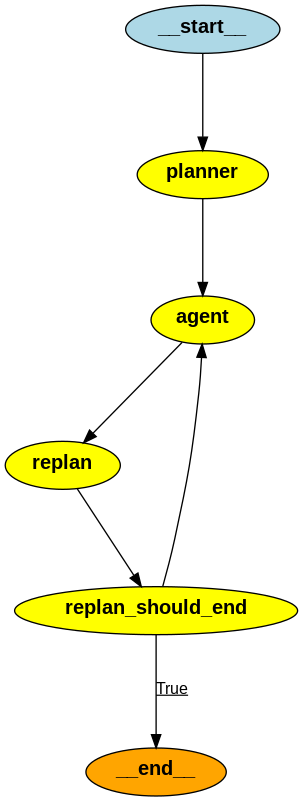

In [4]:

from IPython.display import Image

Image(graph.get_graph().draw_png())

In [15]:
state = {
  "input": {
    "input": "good morning"
  },
  "plan": [
    {
      "key": "General_conv",
      "value": "respond with 'good morning' to user"
    }
  ],
  "past_steps": [
    "respond with 'good morning' to user",
    " Good morning there! I hope this new day brings you joy and positivity. Is there anything specific I can help you with today?"
  ],
  "response": None
}

In [16]:
len(state['plan'])

1

In [2]:
def factorial(x):
    """This is a recursive function
    to find the factorial of an integer"""

    if x == 1:
        return 1
    else:
        k = (x * factorial(x-1))
        return (x * factorial(x-1))


num = 3
print("The factorial of", num, "is", factorial(num))

The factorial of 3 is 6


In [4]:
from langchain_core.runnables import RunnableGenerator
from typing import Iterator


def _generate_immediate_error(input: Iterator) -> Iterator[str]:
    raise ValueError()
    yield ""

def _generate(input: Iterator) -> Iterator[str]:
    try:
        yield from input["exception"].args[0]
    except KeyError:
        yield from "An error occurred."

runnable = RunnableGenerator(_generate_immediate_error).with_fallbacks(
    [RunnableGenerator(_generate)],
    exception_key="exception"
)
print(''.join(runnable.stream([])))  # An error occurred.

ValueError: If 'exception_key' is specified then input must be a dictionary.However found a type of <class 'list'> for input

In [1]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize

text = "Natural language processing is an exciting area. Huge budget have been allocated for this."

print(sent_tokenize(text))
print(word_tokenize(text))

[nltk_data] Downloading package punkt to /home/amaithi/nltk_data...


['Natural language processing is an exciting area.', 'Huge budget have been allocated for this.']
['Natural', 'language', 'processing', 'is', 'an', 'exciting', 'area', '.', 'Huge', 'budget', 'have', 'been', 'allocated', 'for', 'this', '.']


[nltk_data]   Package punkt is already up-to-date!


# GROQ

In [1]:
import json
from typing import Any, Callable, Dict, Literal, Optional, Sequence, Type, Union

from langchain_core.output_parsers import (
    BaseGenerationOutputParser,
    BaseOutputParser,
    JsonOutputParser,
)
from langchain_core.output_parsers.openai_functions import (
    JsonOutputFunctionsParser,
    PydanticAttrOutputFunctionsParser,
    PydanticOutputFunctionsParser,
)
from langchain_core.prompts import BasePromptTemplate
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.runnables import Runnable
from langchain_core.utils.function_calling import (
    convert_to_openai_function,
    convert_to_openai_tool,
)

from langchain.output_parsers import (
    JsonOutputKeyToolsParser,
    PydanticOutputParser,
    PydanticToolsParser,
)


def create_openai_fn_runnable(
    functions: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable]],
    llm: Runnable,
    prompt: Optional[BasePromptTemplate] = None,
    *,
    enforce_single_function_usage: bool = True,
    output_parser: Optional[Union[BaseOutputParser, BaseGenerationOutputParser]] = None,
    **llm_kwargs: Any,
) -> Runnable:
    """Create a runnable sequence that uses OpenAI functions.

    Args:
        functions: A sequence of either dictionaries, pydantic.BaseModels classes, or
            Python functions. If dictionaries are passed in, they are assumed to
            already be a valid OpenAI functions. If only a single
            function is passed in, then it will be enforced that the model use that
            function. pydantic.BaseModels and Python functions should have docstrings
            describing what the function does. For best results, pydantic.BaseModels
            should have descriptions of the parameters and Python functions should have
            Google Python style args descriptions in the docstring. Additionally,
            Python functions should only use primitive types (str, int, float, bool) or
            pydantic.BaseModels for arguments.
        llm: Language model to use, assumed to support the OpenAI function-calling API.
        prompt: BasePromptTemplate to pass to the model.
        enforce_single_function_usage: only used if a single function is passed in. If
            True, then the model will be forced to use the given function. If False,
            then the model will be given the option to use the given function or not.
        output_parser: BaseLLMOutputParser to use for parsing model outputs. By default
            will be inferred from the function types. If pydantic.BaseModels are passed
            in, then the OutputParser will try to parse outputs using those. Otherwise
            model outputs will simply be parsed as JSON. If multiple functions are
            passed in and they are not pydantic.BaseModels, the chain output will
            include both the name of the function that was returned and the arguments
            to pass to the function.
        **llm_kwargs: Additional named arguments to pass to the language model.

    Returns:
        A runnable sequence that will pass in the given functions to the model when run.

    Example:
        .. code-block:: python

                from typing import Optional

                from langchain.chains.structured_output import create_openai_fn_runnable
                from langchain_openai import ChatOpenAI
                from langchain_core.pydantic_v1 import BaseModel, Field


                class RecordPerson(BaseModel):
                    '''Record some identifying information about a person.'''

                    name: str = Field(..., description="The person's name")
                    age: int = Field(..., description="The person's age")
                    fav_food: Optional[str] = Field(None, description="The person's favorite food")


                class RecordDog(BaseModel):
                    '''Record some identifying information about a dog.'''

                    name: str = Field(..., description="The dog's name")
                    color: str = Field(..., description="The dog's color")
                    fav_food: Optional[str] = Field(None, description="The dog's favorite food")


                llm = ChatOpenAI(model="gpt-4", temperature=0)
                structured_llm = create_openai_fn_runnable([RecordPerson, RecordDog], llm)
                structured_llm.invoke("Harry was a chubby brown beagle who loved chicken)
                # -> RecordDog(name="Harry", color="brown", fav_food="chicken")
    """  # noqa: E501
    if not functions:
        raise ValueError("Need to pass in at least one function. Received zero.")
    openai_functions = [convert_to_openai_function(f) for f in functions]
    llm_kwargs_: Dict[str, Any] = {"functions": openai_functions, **llm_kwargs}
    if len(openai_functions) == 1 and enforce_single_function_usage:
        llm_kwargs_["function_call"] = {"name": openai_functions[0]["name"]}
    output_parser = output_parser or get_openai_output_parser(functions)
    if prompt:
        return prompt | llm.bind(**llm_kwargs_) | output_parser
    else:
        return llm.bind(**llm_kwargs_) | output_parser


def create_structured_output_runnable(
    output_schema: Union[Dict[str, Any], Type[BaseModel]],
    llm: Runnable,
    prompt: Optional[BasePromptTemplate] = None,
    *,
    output_parser: Optional[Union[BaseOutputParser, BaseGenerationOutputParser]] = None,
    enforce_function_usage: bool = True,
    return_single: bool = True,
    mode: Literal[
        "openai-functions", "openai-tools", "openai-json"
    ] = "openai-functions",
    **kwargs: Any,
) -> Runnable:
    """Create a runnable for extracting structured outputs.

    Args:
        output_schema: Either a dictionary or pydantic.BaseModel class. If a dictionary
            is passed in, it's assumed to already be a valid JsonSchema.
            For best results, pydantic.BaseModels should have docstrings describing what
            the schema represents and descriptions for the parameters.
        llm: Language model to use. Assumed to support the OpenAI function-calling API 
            if mode is 'openai-function'. Assumed to support OpenAI response_format 
            parameter if mode is 'openai-json'.
        prompt: BasePromptTemplate to pass to the model. If mode is 'openai-json' and 
            prompt has input variable 'output_schema' then the given output_schema 
            will be converted to a JsonSchema and inserted in the prompt.
        output_parser: Output parser to use for parsing model outputs. By default
            will be inferred from the function types. If pydantic.BaseModel is passed
            in, then the OutputParser will try to parse outputs using the pydantic 
            class. Otherwise model outputs will be parsed as JSON.
        mode: How structured outputs are extracted from the model. If 'openai-functions' 
            then OpenAI function calling is used with the deprecated 'functions', 
            'function_call' schema. If 'openai-tools' then OpenAI function 
            calling with the latest 'tools', 'tool_choice' schema is used. This is 
            recommended over 'openai-functions'. If 'openai-json' then OpenAI model 
            with response_format set to JSON is used.
        enforce_function_usage: Only applies when mode is 'openai-tools' or 
            'openai-functions'. If True, then the model will be forced to use the given 
            output schema. If False, then the model can elect whether to use the output 
            schema.
        return_single: Only applies when mode is 'openai-tools'. Whether to a list of 
            structured outputs or a single one. If True and model does not return any 
            structured outputs then chain output is None. If False and model does not 
            return any structured outputs then chain output is an empty list.
        **kwargs: Additional named arguments.

    Returns:
        A runnable sequence that will return a structured output(s) matching the given 
            output_schema.
    
    OpenAI tools example with Pydantic schema (mode='openai-tools'):
        .. code-block:: python
        
                from typing import Optional

                from langchain.chains import create_structured_output_runnable
                from langchain_openai import ChatOpenAI
                from langchain_core.pydantic_v1 import BaseModel, Field


                class RecordDog(BaseModel):
                    '''Record some identifying information about a dog.'''

                    name: str = Field(..., description="The dog's name")
                    color: str = Field(..., description="The dog's color")
                    fav_food: Optional[str] = Field(None, description="The dog's favorite food")

                llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
                prompt = ChatPromptTemplate.from_messages(
                    [
                        ("system", "You are an extraction algorithm. Please extract every possible instance"), 
                        ('human', '{input}')
                    ]
                )
                structured_llm = create_structured_output_runnable(
                    RecordDog, 
                    llm, 
                    mode="openai-tools", 
                    enforce_function_usage=True, 
                    return_single=True
                )
                structured_llm.invoke({"input": "Harry was a chubby brown beagle who loved chicken"})
                # -> RecordDog(name="Harry", color="brown", fav_food="chicken")
                
    OpenAI tools example with dict schema (mode="openai-tools"):
        .. code-block:: python
        
                from typing import Optional

                from langchain.chains import create_structured_output_runnable
                from langchain_openai import ChatOpenAI


                dog_schema = {
                    "type": "function",
                    "function": {
                        "name": "record_dog",
                        "description": "Record some identifying information about a dog.",
                        "parameters": {
                            "type": "object",
                            "properties": {
                                "name": {
                                    "description": "The dog's name",
                                    "type": "string"
                                },
                                "color": {
                                    "description": "The dog's color",
                                    "type": "string"
                                },
                                "fav_food": {
                                    "description": "The dog's favorite food",
                                    "type": "string"
                                }
                            },
                            "required": ["name", "color"]
                        }
                    }
                }


                llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
                structured_llm = create_structured_output_runnable(
                    doc_schema, 
                    llm, 
                    mode="openai-tools", 
                    enforce_function_usage=True, 
                    return_single=True
                )
                structured_llm.invoke("Harry was a chubby brown beagle who loved chicken")
                # -> {'name': 'Harry', 'color': 'brown', 'fav_food': 'chicken'}
    
    OpenAI functions example (mode="openai-functions"):
        .. code-block:: python

                from typing import Optional

                from langchain.chains import create_structured_output_runnable
                from langchain_openai import ChatOpenAI
                from langchain_core.pydantic_v1 import BaseModel, Field

                class Dog(BaseModel):
                    '''Identifying information about a dog.'''

                    name: str = Field(..., description="The dog's name")
                    color: str = Field(..., description="The dog's color")
                    fav_food: Optional[str] = Field(None, description="The dog's favorite food")

                llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
                structured_llm = create_structured_output_runnable(Dog, llm, mode="openai-functions")
                structured_llm.invoke("Harry was a chubby brown beagle who loved chicken")
                # -> Dog(name="Harry", color="brown", fav_food="chicken")
                
    OpenAI functions with prompt example:
        .. code-block:: python

                from typing import Optional

                from langchain.chains import create_structured_output_runnable
                from langchain_openai import ChatOpenAI
                from langchain_core.prompts import ChatPromptTemplate
                from langchain_core.pydantic_v1 import BaseModel, Field

                class Dog(BaseModel):
                    '''Identifying information about a dog.'''

                    name: str = Field(..., description="The dog's name")
                    color: str = Field(..., description="The dog's color")
                    fav_food: Optional[str] = Field(None, description="The dog's favorite food")

                llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
                structured_llm = create_structured_output_runnable(Dog, llm, mode="openai-functions")
                system = '''Extract information about any dogs mentioned in the user input.'''
                prompt = ChatPromptTemplate.from_messages(
                    [("system", system), ("human", "{input}"),]
                )
                chain = prompt | structured_llm
                chain.invoke({"input": "Harry was a chubby brown beagle who loved chicken"})
                # -> Dog(name="Harry", color="brown", fav_food="chicken")
    OpenAI json response format example (mode="openai-json"):
        .. code-block:: python
        
                from typing import Optional

                from langchain.chains import create_structured_output_runnable
                from langchain_openai import ChatOpenAI
                from langchain_core.prompts import ChatPromptTemplate
                from langchain_core.pydantic_v1 import BaseModel, Field

                class Dog(BaseModel):
                    '''Identifying information about a dog.'''

                    name: str = Field(..., description="The dog's name")
                    color: str = Field(..., description="The dog's color")
                    fav_food: Optional[str] = Field(None, description="The dog's favorite food")

                llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
                structured_llm = create_structured_output_runnable(Dog, llm, mode="openai-json")
                system = '''You are a world class assistant for extracting information in structured JSON formats. \
                
                Extract a valid JSON blob from the user input that matches the following JSON Schema:
                
                {output_schema}'''
                prompt = ChatPromptTemplate.from_messages(
                    [("system", system), ("human", "{input}"),]
                )
                chain = prompt | structured_llm
                chain.invoke({"input": "Harry was a chubby brown beagle who loved chicken"})
    """  # noqa: E501
    # for backwards compatibility
    force_function_usage = kwargs.get(
        "enforce_single_function_usage", enforce_function_usage
    )

    if mode == "openai-tools":
        # Protect against typos in kwargs
        keys_in_kwargs = set(kwargs.keys())
        # Backwards compatibility keys
        unrecognized_keys = keys_in_kwargs - {"enforce_single_function_usage"}
        if unrecognized_keys:
            raise TypeError(
                f"Got an unexpected keyword argument(s): {unrecognized_keys}."
            )

        return _create_openai_tools_runnable(
            output_schema,
            llm,
            prompt=prompt,
            output_parser=output_parser,
            enforce_tool_usage=force_function_usage,
            first_tool_only=return_single,
        )

    elif mode == "openai-functions":
        return _create_openai_functions_structured_output_runnable(
            output_schema,
            llm,
            prompt=prompt,
            output_parser=output_parser,
            enforce_single_function_usage=force_function_usage,
            **kwargs,  # llm-specific kwargs
        )
    elif mode == "openai-json":
        if force_function_usage:
            raise ValueError(
                "enforce_single_function_usage is not supported for mode='openai-json'."
            )
        return _create_openai_json_runnable(
            output_schema, llm, prompt=prompt, output_parser=output_parser, **kwargs
        )
    else:
        raise ValueError(
            f"Invalid mode {mode}. Expected one of 'openai-tools', 'openai-functions', "
            f"'openai-json'."
        )


def _create_openai_tools_runnable(
    tool: Union[Dict[str, Any], Type[BaseModel], Callable],
    llm: Runnable,
    *,
    prompt: Optional[BasePromptTemplate],
    output_parser: Optional[Union[BaseOutputParser, BaseGenerationOutputParser]],
    enforce_tool_usage: bool,
    first_tool_only: bool,
) -> Runnable:
    oai_tool = convert_to_openai_tool(tool)
    llm_kwargs: Dict[str, Any] = {"tools": [oai_tool]}
    if enforce_tool_usage:
        llm_kwargs["tool_choice"] = {
            "type": "function",
            "function": {"name": oai_tool["function"]["name"]},
        }
    output_parser = output_parser or _get_openai_tool_output_parser(
        tool, first_tool_only=first_tool_only
    )
    if prompt:
        return prompt | llm.bind(**llm_kwargs) | output_parser
    else:
        return llm.bind(**llm_kwargs) | output_parser


def _get_openai_tool_output_parser(
    tool: Union[Dict[str, Any], Type[BaseModel], Callable],
    *,
    first_tool_only: bool = False,
) -> Union[BaseOutputParser, BaseGenerationOutputParser]:
    if isinstance(tool, type) and issubclass(tool, BaseModel):
        output_parser: Union[
            BaseOutputParser, BaseGenerationOutputParser
        ] = PydanticToolsParser(tools=[tool], first_tool_only=first_tool_only)
    else:
        key_name = convert_to_openai_tool(tool)["function"]["name"]
        output_parser = JsonOutputKeyToolsParser(
            first_tool_only=first_tool_only, key_name=key_name
        )
    return output_parser


def get_openai_output_parser(
    functions: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable]],
) -> Union[BaseOutputParser, BaseGenerationOutputParser]:
    """Get the appropriate function output parser given the user functions.

    Args:
        functions: Sequence where element is a dictionary, a pydantic.BaseModel class,
            or a Python function. If a dictionary is passed in, it is assumed to
            already be a valid OpenAI function.

    Returns:
        A PydanticOutputFunctionsParser if functions are Pydantic classes, otherwise
            a JsonOutputFunctionsParser. If there's only one function and it is
            not a Pydantic class, then the output parser will automatically extract
            only the function arguments and not the function name.
    """
    if isinstance(functions[0], type) and issubclass(functions[0], BaseModel):
        if len(functions) > 1:
            pydantic_schema: Union[Dict, Type[BaseModel]] = {
                convert_to_openai_function(fn)["name"]: fn for fn in functions
            }
        else:
            pydantic_schema = functions[0]
        output_parser: Union[
            BaseOutputParser, BaseGenerationOutputParser
        ] = PydanticOutputFunctionsParser(pydantic_schema=pydantic_schema)
    else:
        output_parser = JsonOutputFunctionsParser(args_only=len(functions) <= 1)
    return output_parser


def _create_openai_json_runnable(
    output_schema: Union[Dict[str, Any], Type[BaseModel]],
    llm: Runnable,
    prompt: Optional[BasePromptTemplate] = None,
    *,
    output_parser: Optional[Union[BaseOutputParser, BaseGenerationOutputParser]] = None,
) -> Runnable:
    """"""
    if isinstance(output_schema, type) and issubclass(output_schema, BaseModel):
        output_parser = output_parser or PydanticOutputParser(
            pydantic_object=output_schema,
        )
        schema_as_dict = convert_to_openai_function(output_schema)["parameters"]
    else:
        output_parser = output_parser or JsonOutputParser()
        schema_as_dict = output_schema

    llm = llm.bind(response_format={"type": "json_object"})
    if prompt:
        if "output_schema" in prompt.input_variables:
            prompt = prompt.partial(output_schema=json.dumps(schema_as_dict, indent=2))

        return prompt | llm | output_parser
    else:
        return llm | output_parser


def _create_openai_functions_structured_output_runnable(
    output_schema: Union[Dict[str, Any], Type[BaseModel]],
    llm: Runnable,
    prompt: Optional[BasePromptTemplate] = None,
    *,
    output_parser: Optional[Union[BaseOutputParser, BaseGenerationOutputParser]] = None,
    **llm_kwargs: Any,
) -> Runnable:
    if isinstance(output_schema, dict):
        function: Any = {
            "name": "output_formatter",
            "description": (
                "Output formatter. Should always be used to format your response to the"
                " user."
            ),
            "parameters": output_schema,
        }
    else:

        class _OutputFormatter(BaseModel):
            """Output formatter. Should always be used to format your response to the user."""  # noqa: E501

            output: output_schema  # type: ignore

        function = _OutputFormatter
        output_parser = output_parser or PydanticAttrOutputFunctionsParser(
            pydantic_schema=_OutputFormatter, attr_name="output"
        )
    return create_openai_fn_runnable(
        [function],
        llm,
        prompt=prompt,
        output_parser=output_parser,
        **llm_kwargs,
    )


In [1]:

from langchain_core.pydantic_v1 import BaseModel, Field
from typing_extensions import List
from typing import Literal

class Step(BaseModel):
    key: Literal["Food_crew", "General_conv", "General_other", "Mediwave_rag", "Travel_crew"] = Field(description='the worker gonna handle this task/step')
    value: str = Field(description='task/ step the worker need to do')


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[Step] 
    


crews = ["Food_crew", "General_conv", "General_other", "Mediwave_rag", "Travel_crew"]

function = {'name': 'plan',
 'description': '',
 
 'parameters': {
   'type': 'array',
   'properties': {
     'key': {
       "enum": f"{crews}",
       'description': 'the worker gonna handle this task/step',
       'type': 'string'},
     'value': {
       'description': 'task/ step the worker need to do',
      'type': 'string'}
     },
                    
    'required': ['plan'],
  }
}


from langchain_core.pydantic_v1 import BaseModel
import os
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_community.chat_models.ollama import ChatOllama

from langchain_groq.chat_models import ChatGroq

    
# from langchain.chains.openai_functions import create_structured_output_runnable

from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_template(
    """For the given user input, come up with a simple step by step plan but don't provide answer coz you have tools to figure out things. if the input requires multiple steps(combintion of multiple tools) then create a list or else just give direct single step with proper input to the selected tool.\
        
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
    
    if the user asks anything related to food, receipies, and it's related stuffs use 'Food_crew' key,
        if the user asks anything related to mediwave and it's related stuffs use 'Mediwave_rag' key,    
        if the user makes conversation like hi, hello and something like that, jokes and funny conversations then use 'General_conv' key and don't provide answer to it just give what user asked,
        if the user asks anything related to weather, time, wikipedia and it's related stuffs use 'General_other' key,
        if the user asks anything related to travel, exploration, city tour and it's related stuffs use 'Travel_crew' key.
    
    always plan minimal steps. make multiple steps only if it is necessary. don't make unnecessary steps, make sure the steps satisfy the original user input.
    
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

only add the actionable step not the empty steps..

user input : {objective}"""
)

# llm = ChatOllama(model=os.environ['LLM'], 
#                  stop= [
#                    os.environ['LLM_START_PARAM'],
#                    os.environ['LLM_STOP_PARAM']
#                    ]
#                  )

llm = ChatGroq(
  model=os.environ['LLM'],
  api_key=os.environ['GROQ_API_KEY']
)

planner = planner_prompt | llm.with_structured_output(
  schema=Plan,
  method='function_calling'
)


# planner = create_structured_output_runnable(
#     function, 
#     llm,
#     planner_prompt,
#     enforce_function_usage = True,
# ).with_retry(
#   retry_if_exception_type = (ValueError, KeyError),
#   stop_after_attempt = 4
# )




/home/amaithi/projects/weaviate/langgraph-final/.venv/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The method `ChatGroq.with_structured_output` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [2]:
plan = planner.invoke({"objective": "good morning"})


In [3]:
plan.dict()['steps']

[{'key': 'General_conv', 'value': 'good morning'}]

In [1]:
"""Groq Chat wrapper."""

from __future__ import annotations

import os
import warnings
from operator import itemgetter
from typing import (
    Any,
    AsyncIterator,
    Callable,
    Dict,
    Iterator,
    List,
    Literal,
    Mapping,
    Optional,
    Sequence,
    Tuple,
    Type,
    TypedDict,
    Union,
    cast,
)

from langchain_core._api import beta
from langchain_core.callbacks import (
    AsyncCallbackManagerForLLMRun,
    CallbackManagerForLLMRun,
)
from langchain_core.language_models import LanguageModelInput
from langchain_core.language_models.chat_models import (
    BaseChatModel,
    agenerate_from_stream,
    generate_from_stream,
)
from langchain_core.messages import (
    AIMessage,
    AIMessageChunk,
    BaseMessage,
    BaseMessageChunk,
    ChatMessage,
    ChatMessageChunk,
    FunctionMessage,
    FunctionMessageChunk,
    HumanMessage,
    HumanMessageChunk,
    SystemMessage,
    SystemMessageChunk,
    ToolMessage,
    ToolMessageChunk,
)
from langchain_core.output_parsers import (
    JsonOutputParser,
    PydanticOutputParser,
)
from langchain_core.output_parsers.base import OutputParserLike
from langchain_core.output_parsers.openai_tools import (
    JsonOutputKeyToolsParser,
    PydanticToolsParser,
    make_invalid_tool_call,
    parse_tool_call,
)
from langchain_core.outputs import ChatGeneration, ChatGenerationChunk, ChatResult
from langchain_core.pydantic_v1 import BaseModel, Field, SecretStr, root_validator
from langchain_core.runnables import Runnable, RunnableMap, RunnablePassthrough
from langchain_core.tools import BaseTool
from langchain_core.utils import (
    convert_to_secret_str,
    get_from_dict_or_env,
    get_pydantic_field_names,
)
from langchain_core.utils.function_calling import (
    convert_to_openai_function,
    convert_to_openai_tool,
)


class ChatGroq(BaseChatModel):
    """`Groq` Chat large language models API.

    To use, you should have the
    environment variable ``GROQ_API_KEY`` set with your API key.

    Any parameters that are valid to be passed to the groq.create call can be passed
    in, even if not explicitly saved on this class.

    Example:
        .. code-block:: python

            from langchain_groq import ChatGroq

            model = ChatGroq(model_name="mixtral-8x7b-32768")
    """

    client: Any = Field(default=None, exclude=True)  #: :meta private:
    async_client: Any = Field(default=None, exclude=True)  #: :meta private:
    model_name: str = Field(default="mixtral-8x7b-32768", alias="model")
    """Model name to use."""
    temperature: float = 0.7
    """What sampling temperature to use."""
    model_kwargs: Dict[str, Any] = Field(default_factory=dict)
    """Holds any model parameters valid for `create` call not explicitly specified."""
    groq_api_key: Optional[SecretStr] = Field(default=None, alias="api_key")
    """Automatically inferred from env var `groq_API_KEY` if not provided."""
    groq_api_base: Optional[str] = Field(default=None, alias="base_url")
    """Base URL path for API requests, leave blank if not using a proxy or service
        emulator."""
    # to support explicit proxy for Groq
    groq_proxy: Optional[str] = None
    request_timeout: Union[float, Tuple[float, float], Any, None] = Field(
        default=None, alias="timeout"
    )
    """Timeout for requests to Groq completion API. Can be float, httpx.Timeout or
        None."""
    max_retries: int = 2
    """Maximum number of retries to make when generating."""
    streaming: bool = False
    """Whether to stream the results or not."""
    n: int = 1
    """Number of chat completions to generate for each prompt."""
    max_tokens: Optional[int] = None
    """Maximum number of tokens to generate."""
    default_headers: Union[Mapping[str, str], None] = None
    default_query: Union[Mapping[str, object], None] = None
    # Configure a custom httpx client. See the
    # [httpx documentation](https://www.python-httpx.org/api/#client) for more details.
    http_client: Union[Any, None] = None
    """Optional httpx.Client."""

    class Config:
        """Configuration for this pydantic object."""

        allow_population_by_field_name = True

    @root_validator(pre=True)
    def build_extra(cls, values: Dict[str, Any]) -> Dict[str, Any]:
        """Build extra kwargs from additional params that were passed in."""
        all_required_field_names = get_pydantic_field_names(cls)
        extra = values.get("model_kwargs", {})
        for field_name in list(values):
            if field_name in extra:
                raise ValueError(f"Found {field_name} supplied twice.")
            if field_name not in all_required_field_names:
                warnings.warn(
                    f"""WARNING! {field_name} is not default parameter.
                    {field_name} was transferred to model_kwargs.
                    Please confirm that {field_name} is what you intended."""
                )
                extra[field_name] = values.pop(field_name)

        invalid_model_kwargs = all_required_field_names.intersection(extra.keys())
        if invalid_model_kwargs:
            raise ValueError(
                f"Parameters {invalid_model_kwargs} should be specified explicitly. "
                f"Instead they were passed in as part of `model_kwargs` parameter."
            )

        values["model_kwargs"] = extra
        return values

    @root_validator()
    def validate_environment(cls, values: Dict) -> Dict:
        """Validate that api key and python package exists in environment."""
        if values["n"] < 1:
            raise ValueError("n must be at least 1.")
        if values["n"] > 1 and values["streaming"]:
            raise ValueError("n must be 1 when streaming.")

        if values["temperature"] == 0:
            values["temperature"] = 1e-8

        values["groq_api_key"] = convert_to_secret_str(
            get_from_dict_or_env(values, "groq_api_key", "GROQ_API_KEY")
        )
        values["groq_api_base"] = values["groq_api_base"] or os.getenv("GROQ_API_BASE")
        values["groq_proxy"] = values["groq_proxy"] = os.getenv("GROQ_PROXY")

        client_params = {
            "api_key": values["groq_api_key"].get_secret_value(),
            "base_url": values["groq_api_base"],
            "timeout": values["request_timeout"],
            "max_retries": values["max_retries"],
            "default_headers": values["default_headers"],
            "default_query": values["default_query"],
            "http_client": values["http_client"],
        }

        try:
            import groq

            if not values.get("client"):
                values["client"] = groq.Groq(**client_params).chat.completions
            if not values.get("async_client"):
                values["async_client"] = groq.AsyncGroq(
                    **client_params
                ).chat.completions
        except ImportError:
            raise ImportError(
                "Could not import groq python package. "
                "Please install it with `pip install groq`."
            )
        return values

    #
    # Serializable class method overrides
    #
    @property
    def lc_secrets(self) -> Dict[str, str]:
        return {"groq_api_key": "GROQ_API_KEY"}

    @classmethod
    def is_lc_serializable(cls) -> bool:
        """Return whether this model can be serialized by Langchain."""
        return True

    #
    # BaseChatModel method overrides
    #
    @property
    def _llm_type(self) -> str:
        """Return type of model."""
        return "groq-chat"

    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:
        if self.streaming:
            stream_iter = self._stream(
                messages, stop=stop, run_manager=run_manager, **kwargs
            )
            return generate_from_stream(stream_iter)
        message_dicts, params = self._create_message_dicts(messages, stop)
        params = {
            **params,
            **kwargs,
        }
        response = self.client.create(messages=message_dicts, **params)
        return self._create_chat_result(response)

    async def _agenerate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[AsyncCallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:
        if self.streaming:
            stream_iter = self._astream(
                messages, stop=stop, run_manager=run_manager, **kwargs
            )
            return await agenerate_from_stream(stream_iter)

        message_dicts, params = self._create_message_dicts(messages, stop)
        params = {
            **params,
            **kwargs,
        }
        response = await self.async_client.create(messages=message_dicts, **params)
        return self._create_chat_result(response)

    def _stream(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> Iterator[ChatGenerationChunk]:
        message_dicts, params = self._create_message_dicts(messages, stop)

        # groq api does not support streaming with tools yet
        if "tools" in kwargs:
            response = self.client.create(
                messages=message_dicts, **{**params, **kwargs}
            )
            chat_result = self._create_chat_result(response)
            generation = chat_result.generations[0]
            message = generation.message
            tool_call_chunks = [
                {
                    "name": rtc["function"].get("name"),
                    "args": rtc["function"].get("arguments"),
                    "id": rtc.get("id"),
                    "index": rtc.get("index"),
                }
                for rtc in message.additional_kwargs.get("tool_calls", [])
            ]
            chunk_ = ChatGenerationChunk(
                message=AIMessageChunk(
                    content=message.content,
                    additional_kwargs=message.additional_kwargs,
                    tool_call_chunks=tool_call_chunks,
                ),
                generation_info=generation.generation_info,
            )
            if run_manager:
                geninfo = chunk_.generation_info or {}
                run_manager.on_llm_new_token(
                    chunk_.text,
                    chunk=chunk_,
                    logprobs=geninfo.get("logprobs"),
                )
            yield chunk_
            return

        params = {**params, **kwargs, "stream": True}

        default_chunk_class = AIMessageChunk
        for chunk in self.client.create(messages=message_dicts, **params):
            if not isinstance(chunk, dict):
                chunk = chunk.dict()
            if len(chunk["choices"]) == 0:
                continue
            choice = chunk["choices"][0]
            chunk = _convert_delta_to_message_chunk(
                choice["delta"], default_chunk_class
            )
            generation_info = {}
            if finish_reason := choice.get("finish_reason"):
                generation_info["finish_reason"] = finish_reason
            logprobs = choice.get("logprobs")
            if logprobs:
                generation_info["logprobs"] = logprobs
            default_chunk_class = chunk.__class__
            chunk = ChatGenerationChunk(
                message=chunk, generation_info=generation_info or None
            )

            if run_manager:
                run_manager.on_llm_new_token(chunk.text, chunk=chunk, logprobs=logprobs)
            yield chunk

    async def _astream(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[AsyncCallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> AsyncIterator[ChatGenerationChunk]:
        message_dicts, params = self._create_message_dicts(messages, stop)

        # groq api does not support streaming with tools yet
        if "tools" in kwargs:
            response = await self.async_client.create(
                messages=message_dicts, **{**params, **kwargs}
            )
            chat_result = self._create_chat_result(response)
            generation = chat_result.generations[0]
            message = generation.message
            tool_call_chunks = [
                {
                    "name": rtc["function"].get("name"),
                    "args": rtc["function"].get("arguments"),
                    "id": rtc.get("id"),
                    "index": rtc.get("index"),
                }
                for rtc in message.additional_kwargs.get("tool_calls", [])
            ]
            chunk_ = ChatGenerationChunk(
                message=AIMessageChunk(
                    content=message.content,
                    additional_kwargs=message.additional_kwargs,
                    tool_call_chunks=tool_call_chunks,
                ),
                generation_info=generation.generation_info,
            )
            if run_manager:
                geninfo = chunk_.generation_info or {}
                await run_manager.on_llm_new_token(
                    chunk_.text,
                    chunk=chunk_,
                    logprobs=geninfo.get("logprobs"),
                )
            yield chunk_
            return

        params = {**params, **kwargs, "stream": True}

        default_chunk_class = AIMessageChunk
        async for chunk in await self.async_client.create(
            messages=message_dicts, **params
        ):
            if not isinstance(chunk, dict):
                chunk = chunk.dict()
            if len(chunk["choices"]) == 0:
                continue
            choice = chunk["choices"][0]
            chunk = _convert_delta_to_message_chunk(
                choice["delta"], default_chunk_class
            )
            generation_info = {}
            if finish_reason := choice.get("finish_reason"):
                generation_info["finish_reason"] = finish_reason
            logprobs = choice.get("logprobs")
            if logprobs:
                generation_info["logprobs"] = logprobs
            default_chunk_class = chunk.__class__
            chunk = ChatGenerationChunk(
                message=chunk, generation_info=generation_info or None
            )

            if run_manager:
                await run_manager.on_llm_new_token(
                    token=chunk.text, chunk=chunk, logprobs=logprobs
                )
            yield chunk

    #
    # Internal methods
    #
    @property
    def _default_params(self) -> Dict[str, Any]:
        """Get the default parameters for calling Groq API."""
        params = {
            "model": self.model_name,
            "stream": self.streaming,
            "n": self.n,
            "temperature": self.temperature,
            **self.model_kwargs,
        }
        if self.max_tokens is not None:
            params["max_tokens"] = self.max_tokens
        return params

    def _create_chat_result(self, response: Union[dict, BaseModel]) -> ChatResult:
        generations = []
        if not isinstance(response, dict):
            response = response.dict()
        for res in response["choices"]:
            message = _convert_dict_to_message(res["message"])
            generation_info = dict(finish_reason=res.get("finish_reason"))
            if "logprobs" in res:
                generation_info["logprobs"] = res["logprobs"]
            gen = ChatGeneration(
                message=message,
                generation_info=generation_info,
            )
            generations.append(gen)
        token_usage = response.get("usage", {})
        llm_output = {
            "token_usage": token_usage,
            "model_name": self.model_name,
            "system_fingerprint": response.get("system_fingerprint", ""),
        }
        return ChatResult(generations=generations, llm_output=llm_output)

    def _create_message_dicts(
        self, messages: List[BaseMessage], stop: Optional[List[str]]
    ) -> Tuple[List[Dict[str, Any]], Dict[str, Any]]:
        params = self._default_params
        if stop is not None:
            if "stop" in params:
                raise ValueError("`stop` found in both the input and default params.")
            params["stop"] = stop
        message_dicts = [_convert_message_to_dict(m) for m in messages]
        return message_dicts, params

    def _combine_llm_outputs(self, llm_outputs: List[Optional[dict]]) -> dict:
        overall_token_usage: dict = {}
        system_fingerprint = None
        for output in llm_outputs:
            if output is None:
                # Happens in streaming
                continue
            token_usage = output["token_usage"]
            if token_usage is not None:
                for k, v in token_usage.items():
                    if k in overall_token_usage and v is not None:
                        overall_token_usage[k] += v
                    else:
                        overall_token_usage[k] = v
            if system_fingerprint is None:
                system_fingerprint = output.get("system_fingerprint")
        combined = {"token_usage": overall_token_usage, "model_name": self.model_name}
        if system_fingerprint:
            combined["system_fingerprint"] = system_fingerprint
        return combined

    def bind_functions(
        self,
        functions: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        function_call: Optional[
            Union[_FunctionCall, str, Literal["auto", "none"]]
        ] = None,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, BaseMessage]:
        """Bind functions (and other objects) to this chat model.

        Model is compatible with OpenAI function-calling API.

        NOTE: Using bind_tools is recommended instead, as the `functions` and
            `function_call` request parameters are officially deprecated.

        Args:
            functions: A list of function definitions to bind to this chat model.
                Can be  a dictionary, pydantic model, or callable. Pydantic
                models and callables will be automatically converted to
                their schema dictionary representation.
            function_call: Which function to require the model to call.
                Must be the name of the single provided function or
                "auto" to automatically determine which function to call
                (if any).
            **kwargs: Any additional parameters to pass to the
                :class:`~langchain.runnable.Runnable` constructor.
        """

        formatted_functions = [convert_to_openai_function(fn) for fn in functions]
        if function_call is not None:
            function_call = (
                {"name": function_call}
                if isinstance(function_call, str)
                and function_call not in ("auto", "none")
                else function_call
            )
            if isinstance(function_call, dict) and len(formatted_functions) != 1:
                raise ValueError(
                    "When specifying `function_call`, you must provide exactly one "
                    "function."
                )
            if (
                isinstance(function_call, dict)
                and formatted_functions[0]["name"] != function_call["name"]
            ):
                raise ValueError(
                    f"Function call {function_call} was specified, but the only "
                    f"provided function was {formatted_functions[0]['name']}."
                )
            kwargs = {**kwargs, "function_call": function_call}
        return super().bind(
            functions=formatted_functions,
            **kwargs,
        )

    def bind_tools(
        self,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[
            Union[dict, str, Literal["auto", "any", "none"], bool]
        ] = None,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, BaseMessage]:
        """Bind tool-like objects to this chat model.

        Args:
            tools: A list of tool definitions to bind to this chat model.
                Can be  a dictionary, pydantic model, callable, or BaseTool. Pydantic
                models, callables, and BaseTools will be automatically converted to
                their schema dictionary representation.
            tool_choice: Which tool to require the model to call.
                Must be the name of the single provided function,
                "auto" to automatically determine which function to call
                with the option to not call any function, "any" to enforce that some
                function is called, or a dict of the form:
                {"type": "function", "function": {"name": <<tool_name>>}}.
            **kwargs: Any additional parameters to pass to the
                :class:`~langchain.runnable.Runnable` constructor.
        """

        formatted_tools = [convert_to_openai_tool(tool) for tool in tools]
        if tool_choice is not None and tool_choice:
            if isinstance(tool_choice, str) and (
                tool_choice not in ("auto", "any", "none")
            ):
                tool_choice = {"type": "function", "function": {"name": tool_choice}}
            if isinstance(tool_choice, dict) and (len(formatted_tools) != 1):
                raise ValueError(
                    "When specifying `tool_choice`, you must provide exactly one "
                    f"tool. Received {len(formatted_tools)} tools."
                )
            if isinstance(tool_choice, dict) and (
                formatted_tools[0]["function"]["name"]
                != tool_choice["function"]["name"]
            ):
                raise ValueError(
                    f"Tool choice {tool_choice} was specified, but the only "
                    f"provided tool was {formatted_tools[0]['function']['name']}."
                )
            if isinstance(tool_choice, bool):
                if len(tools) > 1:
                    raise ValueError(
                        "tool_choice can only be True when there is one tool. Received "
                        f"{len(tools)} tools."
                    )
                tool_name = formatted_tools[0]["function"]["name"]
                tool_choice = {
                    "type": "function",
                    "function": {"name": tool_name},
                }

            kwargs["tool_choice"] = tool_choice
        return super().bind(tools=formatted_tools, **kwargs)

    @beta()
    def with_structured_output(
        self,
        schema: Optional[Union[Dict, Type[BaseModel]]] = None,
        *,
        method: Literal["function_calling", "json_mode"] = "function_calling",
        include_raw: bool = False,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, Union[Dict, BaseModel]]:
        """Model wrapper that returns outputs formatted to match the given schema.

        Args:
            schema: The output schema as a dict or a Pydantic class. If a Pydantic class
                then the model output will be an object of that class. If a dict then
                the model output will be a dict. With a Pydantic class the returned
                attributes will be validated, whereas with a dict they will not be. If
                `method` is "function_calling" and `schema` is a dict, then the dict
                must match the OpenAI function-calling spec.
            method: The method for steering model generation, either "function_calling"
                or "json_mode". If "function_calling" then the schema will be converted
                to a OpenAI function and the returned model will make use of the
                function-calling API. If "json_mode" then Groq's JSON mode will be
                used. Note that if using "json_mode" then you must include instructions
                for formatting the output into the desired schema into the model call.
            include_raw: If False then only the parsed structured output is returned. If
                an error occurs during model output parsing it will be raised. If True
                then both the raw model response (a BaseMessage) and the parsed model
                response will be returned. If an error occurs during output parsing it
                will be caught and returned as well. The final output is always a dict
                with keys "raw", "parsed", and "parsing_error".

        Returns:
            A Runnable that takes any ChatModel input and returns as output:

                If include_raw is True then a dict with keys:
                    raw: BaseMessage
                    parsed: Optional[_DictOrPydantic]
                    parsing_error: Optional[BaseException]

                If include_raw is False then just _DictOrPydantic is returned,
                where _DictOrPydantic depends on the schema:

                If schema is a Pydantic class then _DictOrPydantic is the Pydantic
                    class.

                If schema is a dict then _DictOrPydantic is a dict.

        Example: Function-calling, Pydantic schema (method="function_calling", include_raw=False):
            .. code-block:: python

                from langchain_groq import ChatGroq
                from langchain_core.pydantic_v1 import BaseModel

                class AnswerWithJustification(BaseModel):
                    '''An answer to the user question along with justification for the answer.'''
                    answer: str
                    justification: str

                llm = ChatGroq(temperature=0)
                structured_llm = llm.with_structured_output(AnswerWithJustification)

                structured_llm.invoke("What weighs more a pound of bricks or a pound of feathers")
                # -> AnswerWithJustification(
                #     answer='A pound of bricks and a pound of feathers weigh the same.'
                #     justification="Both a pound of bricks and a pound of feathers have been defined to have the same weight. The 'pound' is a unit of weight, so any two things that are described as weighing a pound will weigh the same."
                # )

        Example: Function-calling, Pydantic schema (method="function_calling", include_raw=True):
            .. code-block:: python

                from langchain_groq import ChatGroq
                from langchain_core.pydantic_v1 import BaseModel

                class AnswerWithJustification(BaseModel):
                    '''An answer to the user question along with justification for the answer.'''
                    answer: str
                    justification: str

                llm = ChatGroq(temperature=0)
                structured_llm = llm.with_structured_output(AnswerWithJustification, include_raw=True)

                structured_llm.invoke("What weighs more a pound of bricks or a pound of feathers")
                # -> {
                #     'raw': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_01htjn3cspevxbqc1d7nkk8wab', 'function': {'arguments': '{"answer": "A pound of bricks and a pound of feathers weigh the same.", "justification": "Both a pound of bricks and a pound of feathers have been defined to have the same weight. The \'pound\' is a unit of weight, so any two things that are described as weighing a pound will weigh the same.", "unit": "pounds"}', 'name': 'AnswerWithJustification'}, 'type': 'function'}]}, id='run-456beee6-65f6-4e80-88af-a6065480822c-0'),
                #     'parsed': AnswerWithJustification(answer='A pound of bricks and a pound of feathers weigh the same.', justification="Both a pound of bricks and a pound of feathers have been defined to have the same weight. The 'pound' is a unit of weight, so any two things that are described as weighing a pound will weigh the same."),
                #     'parsing_error': None
                # }

        Example: Function-calling, dict schema (method="function_calling", include_raw=False):
            .. code-block:: python

                from langchain_groq import ChatGroq
                from langchain_core.pydantic_v1 import BaseModel
                from langchain_core.utils.function_calling import convert_to_openai_tool

                class AnswerWithJustification(BaseModel):
                    '''An answer to the user question along with justification for the answer.'''
                    answer: str
                    justification: str

                dict_schema = convert_to_openai_tool(AnswerWithJustification)
                llm = ChatGroq(temperature=0)
                structured_llm = llm.with_structured_output(dict_schema)

                structured_llm.invoke("What weighs more a pound of bricks or a pound of feathers")
                # -> {
                #     'answer': 'A pound of bricks and a pound of feathers weigh the same.',
                #     'justification': "Both a pound of bricks and a pound of feathers have been defined to have the same weight. The 'pound' is a unit of weight, so any two things that are described as weighing a pound will weigh the same.", 'unit': 'pounds'}
                # }

        Example: JSON mode, Pydantic schema (method="json_mode", include_raw=True):
            .. code-block::

                from langchain_groq import ChatGroq
                from langchain_core.pydantic_v1 import BaseModel

                class AnswerWithJustification(BaseModel):
                    answer: str
                    justification: str

                llm = ChatGroq(temperature=0)
                structured_llm = llm.with_structured_output(
                    AnswerWithJustification,
                    method="json_mode",
                    include_raw=True
                )

                structured_llm.invoke(
                    "Answer the following question. "
                    "Make sure to return a JSON blob with keys 'answer' and 'justification'.\n\n"
                    "What's heavier a pound of bricks or a pound of feathers?"
                )
                # -> {
                #     'raw': AIMessage(content='{\n  "answer": "A pound of bricks is the same weight as a pound of feathers.",\n  "justification": "Both a pound of bricks and a pound of feathers weigh one pound. The material being weighed does not affect the weight, only the volume or number of items being weighed."\n}', id='run-e5453bc5-5025-4833-95f9-4967bf6d5c4f-0'),
                #     'parsed': AnswerWithJustification(answer='A pound of bricks is the same weight as a pound of feathers.', justification='Both a pound of bricks and a pound of feathers weigh one pound. The material being weighed does not affect the weight, only the volume or number of items being weighed.'),
                #     'parsing_error': None
                # }

        Example: JSON mode, no schema (schema=None, method="json_mode", include_raw=True):
            .. code-block::

                from langchain_groq import ChatGroq

                llm = ChatGroq(temperature=0)
                structured_llm = llm.with_structured_output(method="json_mode", include_raw=True)

                structured_llm.invoke(
                    "Answer the following question. "
                    "Make sure to return a JSON blob with keys 'answer' and 'justification'.\n\n"
                    "What's heavier a pound of bricks or a pound of feathers?"
                )
                # -> {
                #     'raw': AIMessage(content='{\n  "answer": "A pound of bricks is the same weight as a pound of feathers.",\n  "justification": "Both a pound of bricks and a pound of feathers weigh one pound. The material doesn\'t change the weight, only the volume or space that the material takes up."\n}', id='run-a4abbdb6-c20e-456f-bfff-da906a7e76b5-0'),
                #     'parsed': {
                #         'answer': 'A pound of bricks is the same weight as a pound of feathers.',
                #         'justification': "Both a pound of bricks and a pound of feathers weigh one pound. The material doesn't change the weight, only the volume or space that the material takes up."},
                #     'parsing_error': None
                # }


        """  # noqa: E501
        if kwargs:
            raise ValueError(f"Received unsupported arguments {kwargs}")
        is_pydantic_schema = _is_pydantic_class(schema)
        if method == "function_calling":
            if schema is None:
                raise ValueError(
                    "schema must be specified when method is 'function_calling'. "
                    "Received None."
                )
            llm = self.bind_tools([schema], tool_choice=True)
            if is_pydantic_schema:
                output_parser: OutputParserLike = PydanticToolsParser(
                    tools=[schema], first_tool_only=True
                )
            else:
                key_name = convert_to_openai_tool(schema)["function"]["name"]
                output_parser = JsonOutputKeyToolsParser(
                    key_name=key_name, first_tool_only=True
                )
        elif method == "json_mode":
            llm = self.bind(response_format={"type": "json_object"})
            output_parser = (
                PydanticOutputParser(pydantic_object=schema)
                if is_pydantic_schema
                else JsonOutputParser()
            )
        else:
            raise ValueError(
                f"Unrecognized method argument. Expected one of 'function_calling' or "
                f"'json_format'. Received: '{method}'"
            )

        if include_raw:
            parser_assign = RunnablePassthrough.assign(
                parsed=itemgetter("raw") | output_parser, parsing_error=lambda _: None
            )
            parser_none = RunnablePassthrough.assign(parsed=lambda _: None)
            parser_with_fallback = parser_assign.with_fallbacks(
                [parser_none], exception_key="parsing_error"
            )
            return RunnableMap(raw=llm) | parser_with_fallback
        else:
            return llm | output_parser


def _is_pydantic_class(obj: Any) -> bool:
    return isinstance(obj, type) and issubclass(obj, BaseModel)


class _FunctionCall(TypedDict):
    name: str


#
# Type conversion helpers
#
def _convert_message_to_dict(message: BaseMessage) -> dict:
    """Convert a LangChain message to a dictionary.

    Args:
        message: The LangChain message.

    Returns:
        The dictionary.
    """
    message_dict: Dict[str, Any]
    if isinstance(message, ChatMessage):
        message_dict = {"role": message.role, "content": message.content}
    elif isinstance(message, HumanMessage):
        message_dict = {"role": "user", "content": message.content}
    elif isinstance(message, AIMessage):
        message_dict = {"role": "assistant", "content": message.content}
        if "function_call" in message.additional_kwargs:
            message_dict["function_call"] = message.additional_kwargs["function_call"]
            # If function call only, content is None not empty string
            if message_dict["content"] == "":
                message_dict["content"] = None
        if "tool_calls" in message.additional_kwargs:
            message_dict["tool_calls"] = message.additional_kwargs["tool_calls"]
            # If tool calls only, content is None not empty string
            if message_dict["content"] == "":
                message_dict["content"] = None
    elif isinstance(message, SystemMessage):
        message_dict = {"role": "system", "content": message.content}
    elif isinstance(message, FunctionMessage):
        message_dict = {
            "role": "function",
            "content": message.content,
            "name": message.name,
        }
    elif isinstance(message, ToolMessage):
        message_dict = {
            "role": "tool",
            "content": message.content,
            "tool_call_id": message.tool_call_id,
        }
    else:
        raise TypeError(f"Got unknown type {message}")
    if "name" in message.additional_kwargs:
        message_dict["name"] = message.additional_kwargs["name"]
    return message_dict


def _convert_delta_to_message_chunk(
    _dict: Mapping[str, Any], default_class: Type[BaseMessageChunk]
) -> BaseMessageChunk:
    role = cast(str, _dict.get("role"))
    content = cast(str, _dict.get("content") or "")
    additional_kwargs: Dict = {}
    if _dict.get("function_call"):
        function_call = dict(_dict["function_call"])
        if "name" in function_call and function_call["name"] is None:
            function_call["name"] = ""
        additional_kwargs["function_call"] = function_call
    if _dict.get("tool_calls"):
        additional_kwargs["tool_calls"] = _dict["tool_calls"]

    if role == "user" or default_class == HumanMessageChunk:
        return HumanMessageChunk(content=content)
    elif role == "assistant" or default_class == AIMessageChunk:
        return AIMessageChunk(content=content, additional_kwargs=additional_kwargs)
    elif role == "system" or default_class == SystemMessageChunk:
        return SystemMessageChunk(content=content)
    elif role == "function" or default_class == FunctionMessageChunk:
        return FunctionMessageChunk(content=content, name=_dict["name"])
    elif role == "tool" or default_class == ToolMessageChunk:
        return ToolMessageChunk(content=content, tool_call_id=_dict["tool_call_id"])
    elif role or default_class == ChatMessageChunk:
        return ChatMessageChunk(content=content, role=role)
    else:
        return default_class(content=content)  # type: ignore


def _convert_dict_to_message(_dict: Mapping[str, Any]) -> BaseMessage:
    """Convert a dictionary to a LangChain message.

    Args:
        _dict: The dictionary.

    Returns:
        The LangChain message.
    """
    id_ = _dict.get("id")
    role = _dict.get("role")
    if role == "user":
        return HumanMessage(content=_dict.get("content", ""))
    elif role == "assistant":
        content = _dict.get("content", "") or ""
        additional_kwargs: Dict = {}
        if function_call := _dict.get("function_call"):
            additional_kwargs["function_call"] = dict(function_call)
        tool_calls = []
        invalid_tool_calls = []
        if raw_tool_calls := _dict.get("tool_calls"):
            additional_kwargs["tool_calls"] = raw_tool_calls
            for raw_tool_call in raw_tool_calls:
                try:
                    tool_calls.append(parse_tool_call(raw_tool_call, return_id=True))
                except Exception as e:
                    invalid_tool_calls.append(
                        make_invalid_tool_call(raw_tool_call, str(e))
                    )
        return AIMessage(
            content=content,
            id=id_,
            additional_kwargs=additional_kwargs,
            tool_calls=tool_calls,
            invalid_tool_calls=invalid_tool_calls,
        )
    elif role == "system":
        return SystemMessage(content=_dict.get("content", ""))
    elif role == "function":
        return FunctionMessage(content=_dict.get("content", ""), name=_dict.get("name"))
    elif role == "tool":
        additional_kwargs = {}
        if "name" in _dict:
            additional_kwargs["name"] = _dict["name"]
        return ToolMessage(
            content=_dict.get("content", ""),
            tool_call_id=_dict.get("tool_call_id"),
            additional_kwargs=additional_kwargs,
        )
    else:
        return ChatMessage(content=_dict.get("content", ""), role=role)


In [1]:
state = {
  "input": {
    "input": "good morning"
  },
  "plan": [
    {
      "key": "General_conv",
      "value": "respond with 'good morning' to user"
    }
  ],
  "past_steps": [
    "respond with 'good morning' to user",
    " Good morning there! I hope this new day brings you joy and positivity. Is there anything specific I can help you with today?"
  ],
  "response": None
}

In [62]:




from langchain_core.pydantic_v1 import BaseModel, Field
from typing_extensions import List
from typing import Literal

class Step(BaseModel):
    key: Literal["Food_crew", "General_conv", "General_other", "Mediwave_rag", "Travel_crew"] = Field(description='the worker gonna handle this task/step')
    value: str = Field(description='task/ step the worker need to do')


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[Step] 
    





from langchain_core.pydantic_v1 import BaseModel
from langchain_core.prompts import ChatPromptTemplate
# from plan_and_execute.planner import crews
import os

from langchain.globals import set_debug, set_verbose
from langchain_groq.chat_models import ChatGroq
from langchain_core.output_parsers.openai_tools import PydanticToolsParser


set_verbose=True 
set_debug=True

class Response(BaseModel):
    """Response to user."""

    response: str

# response = {'name': 'Response',
#  'description': 'Response to user.',
#  'parameters': {'type': 'object',
#   'properties': {'response': {'type': 'string'}},
#   'required': ['response']}}


# function1 = {'name': 'plan',
#  'description': 'replanner',
 
#  'parameters': {
#    'type': 'array',
#    'properties': {
#      'key': {
#        "enum": f"{crews}",
#        'description': 'the worker gonna handle this task/step'
       
# ,
        
#        'type': 'string'},
#      'value': {
#        'description': 'task/ step the worker need to do',
#       'type': 'string'}
#      },
                    
#     'required': ['plan'],
#   }
# }


replanner_prompt = ChatPromptTemplate.from_template(
   """
you are a planning expert following are the user input, and the plan as well as the performed steps and it's outcomes you're job is to analyse the currently executed steps and its outcome to summarize the final answer to the user question, while providing response make sure the user input is satisfied with the response refer the follow steps to gather the necessary informations for the final response..

user input was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

\n incase you need more information/ execute all steps in the plan to summarize the final answer then do the following.

Update your plan accordingly(remove the completed step). If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done and don't create unnecessary new steps that are not in the original plan. Do not return previously done steps as part of the plan.

only provide the final answer after make sure the user requirement has been satisfied completely.

don't use ```json``` while giving the response

make sure the tool name is either 'Plan' for replan or 'Response' for final answer.

don't make unneccesary steps unrelavant to the original user input.. remove the satisfied step in the given plan. 

don't add any notes to the output.

"""
)

llm = ChatGroq(
  model=os.environ['LLM'],
  api_key=os.environ['GROQ_API_KEY']
)

parser = PydanticToolsParser(tools=[Plan, Response], first_tool_only=True)

llm_func = llm.bind_tools([Plan, Response])

replanner = replanner_prompt | llm_func | parser


# replanner = create_openai_fn_runnable(
    
#     [Plan, Response],
#     llm,
#     replanner_prompt,
# ).with_retry(
#   retry_if_exception_type=(ValueError,KeyError),
#   stop_after_attempt=4,
# )



In [63]:
super_state_ = state.copy()

plan_step = []

for item in state['plan']:
    plan_step.append(item['value'])

super_state_ |= {'plan': plan_step}

output =replanner.invoke(super_state_)

In [66]:
output.response

'Good morning there! I hope this new day brings you joy and positivity. Is there anything specific I can help you with today?'

In [65]:
isinstance(output, Response)

True

In [50]:
out = parser.invoke(output)

In [54]:
out[0]

Response(response='Good morning there! I hope this new day brings you joy and positivity. Is there anything specific I can help you with today?')

In [55]:
# output.tool_calls[0].get('args')



True

In [30]:
output.response

AttributeError: 'AIMessage' object has no attribute 'response'

In [6]:
isinstance(output, Response)

False

In [ ]:
from langchain.output_parsers import PydanticToolsParser

PydanticToolsParser(strict=True, tools=[Plan, Response])